# Visualizing Monetary Policy

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime

def gather_data(data_codes, #dict
                start, #start date (datetime)
                end = datetime.datetime.today(), #end date (datetime)
               freq="M"): #str "D","W","M","Q","A", also "2D", etc...
    df_init = False
    for name, code in data_codes.items():
        if df_init == False:
            # .resample(freq) adjusts frequency, 
            #   choose .first(), .last(). mean(), median(), etc...
            df = web.DataReader(
                code, "fred", start, end).resample(freq).mean()
            df.rename(columns = {code:name}, inplace = True)
            df_init = True
        else:
            df[name] = web.DataReader(
                code, "fred", start, end).resample(freq).mean()
    return df

def bil_to_mil(series):
    return series * 10 ** 3

start = datetime.datetime(1970,1,1)
end = datetime.datetime.today()
freq = "M"

In [2]:
from datlib.plots import *
# from datlib.FRED import *

data_codes= {"Monetary Base":"BOGMBASE",
            "Currency in Circulation":"WCURCIR"}
base = gather_data(data_codes,
                  start,
                  end,
                  freq)

In [3]:
base

,Monetary Base,Currency in Circulation
DATE,,
1970-01-31,76400.0,NaN
1970-02-28,75200.0,NaN
1970-03-31,75300.0,NaN
1970-04-30,76300.0,NaN
1970-05-31,76600.0,NaN
...,...,...
2021-04-30,6042100.0,2154.81925
2021-05-31,6041900.0,2167.93400
2021-06-30,6027100.0,2178.87120


In [4]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR", 
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }

data = gather_data(data_codes = data_codes,
                  start = start,
                  end = end,
                  freq = "M")

In [5]:
bil_to_mil_list = ["Balance Sheet: Total Reserves ($ Mil)",
                  "Balance Sheet: Other Deposits ($ Mil)",
                  "Base: Currency in Circulation ($ Mil)"]
for key in bil_to_mil_list:
    data[key] = bil_to_mil(data[key])

<AxesSubplot:xlabel='DATE'>

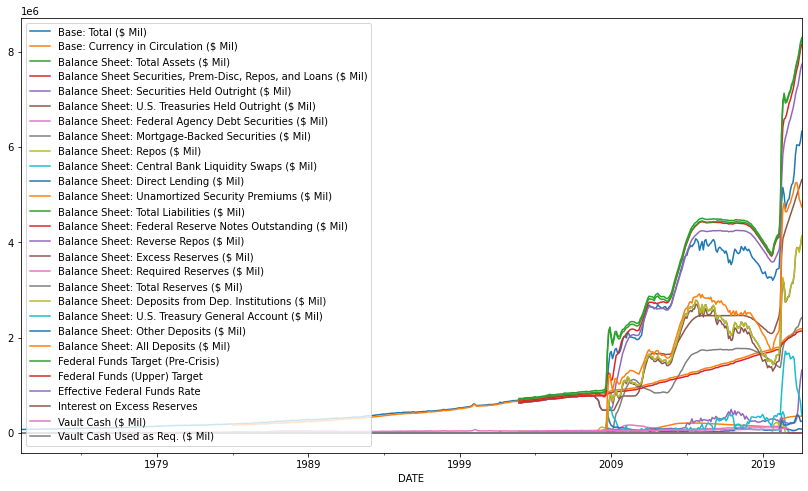

In [6]:
fig, ax = plt.subplots(figsize = (14,8))
data.plot(ax = ax)

In [7]:
from matplotlib.backends.backend_pdf import PdfPages
def plot_lines(df,
               title="",
              linewidth = 1,
              figsize  = (40,20),
              secondary_y = None,
              legend = True, 
               pp = None,
              save_fig = False):
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_title(title)
    # drop empty rows
    df.dropna(axis=0, how = "all").plot.line(
        linewidth = linewidth,
        secondary_y = secondary_y,
        legend = legend,
        ax = ax)
    ax.tick_params(axis="x", rotation = 90)
    # remove ticklines
    ax.tick_params("both", length = 0, which="both")
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x, 2) for x in vals])
    
    #format image filename
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    # create a folder for .png files
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        # save figure as png file
        # bbox_inches = "tight" is for formatting
        plt.savefig("plots/" + filename[:50] + "Lines.png",
                   bbox_inches = "tight")
    if pp != None: 
        pp.savefig(fig, bbox_inches = "tight")

<ipython-input-7-d2f49b60d242>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x, 2) for x in vals])


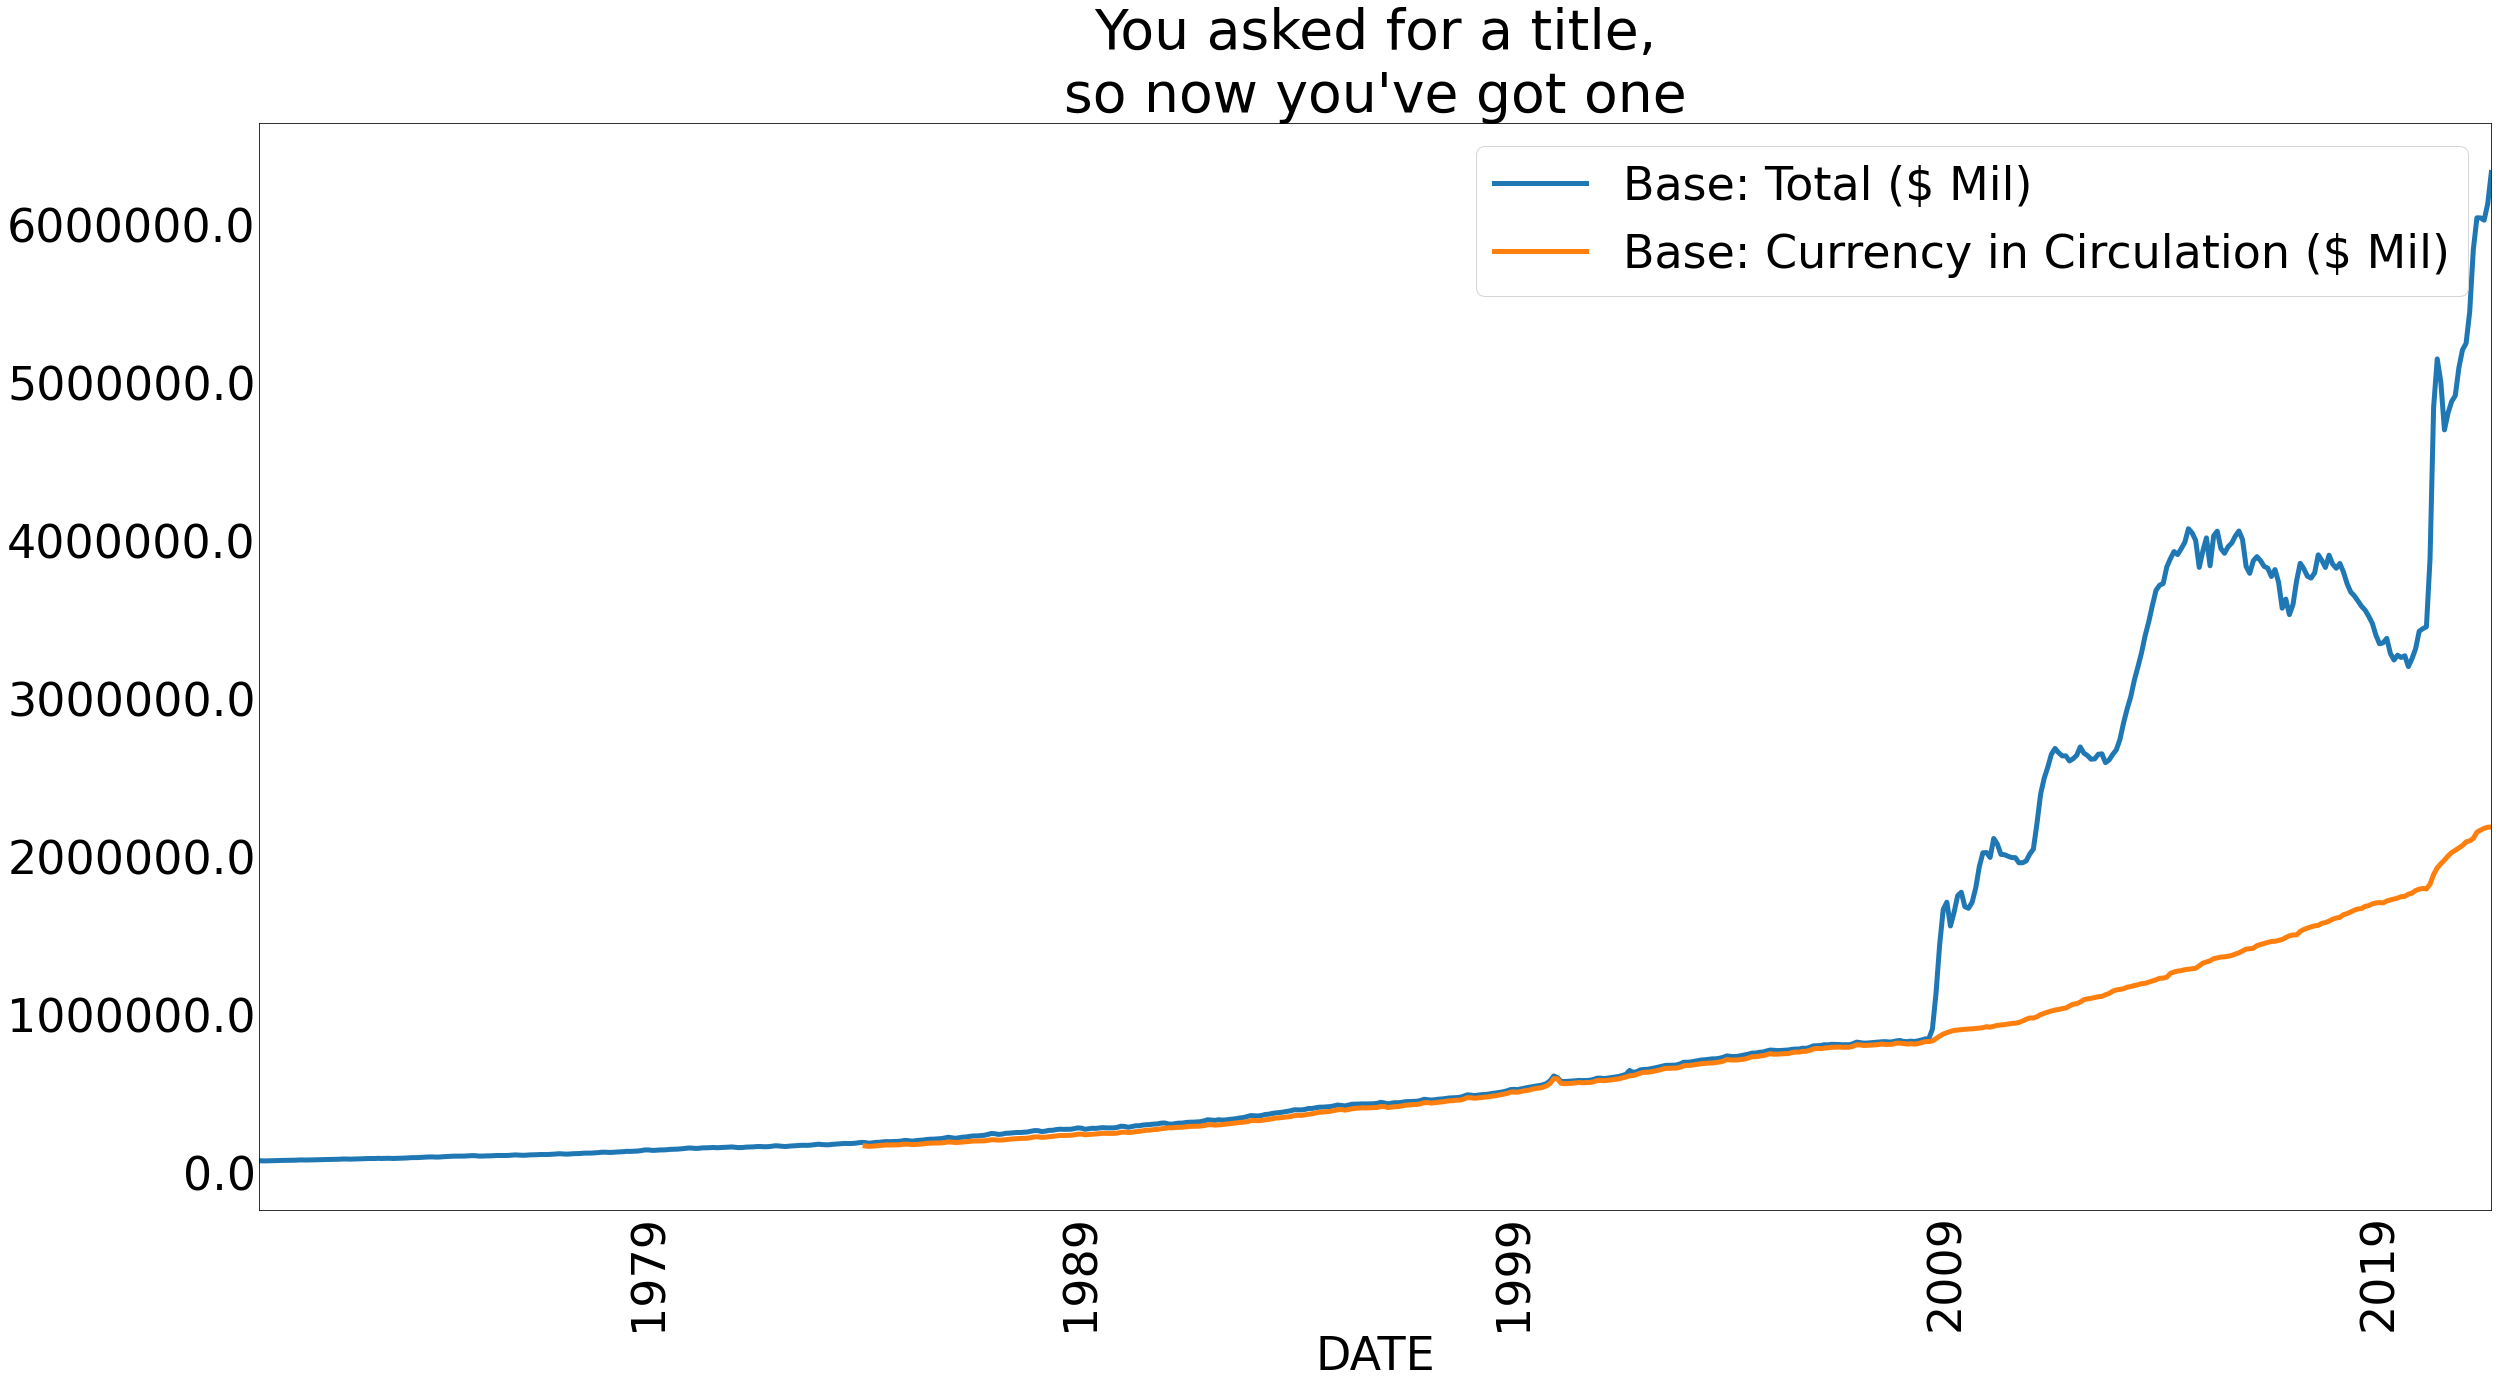

In [8]:
pp = PdfPages("Monetary Base Measures.pdf")

plt.rcParams.update({"font.size": 46})  
plot_vars = ["Base: Total ($ Mil)", 
             "Base: Currency in Circulation ($ Mil)"]
# create a dataframe with specific variables
plot_df = data[plot_vars]
plot_lines(plot_df, 
           title = "You asked for a title,\nso now you've got one", 
           linewidth = 5,
          pp = pp)
pp.close()

In [9]:
def plot_stacked_lines(df,
                      plot_vars,
                      linewidth=1,
                      figsize = (40,20),
                      pp = None,
                      total_var = False):
    fig, ax = plt.subplots(figsize=figsize)
    df[plot_vars].plot.area(stacked = True,
                           linewidth = linewidth,
                           ax = ax)
    if total_var != False:
        df[total_var].plot.line(
            linewidth = linewidth,
            ax = ax,
            c = "k",
            label = total_var,
            ls = "--")
    ax.legend(loc=2, ncol = 1)
    if pp != None: pp.savefig(
                        fig,
                        bbox_inches = "tight")

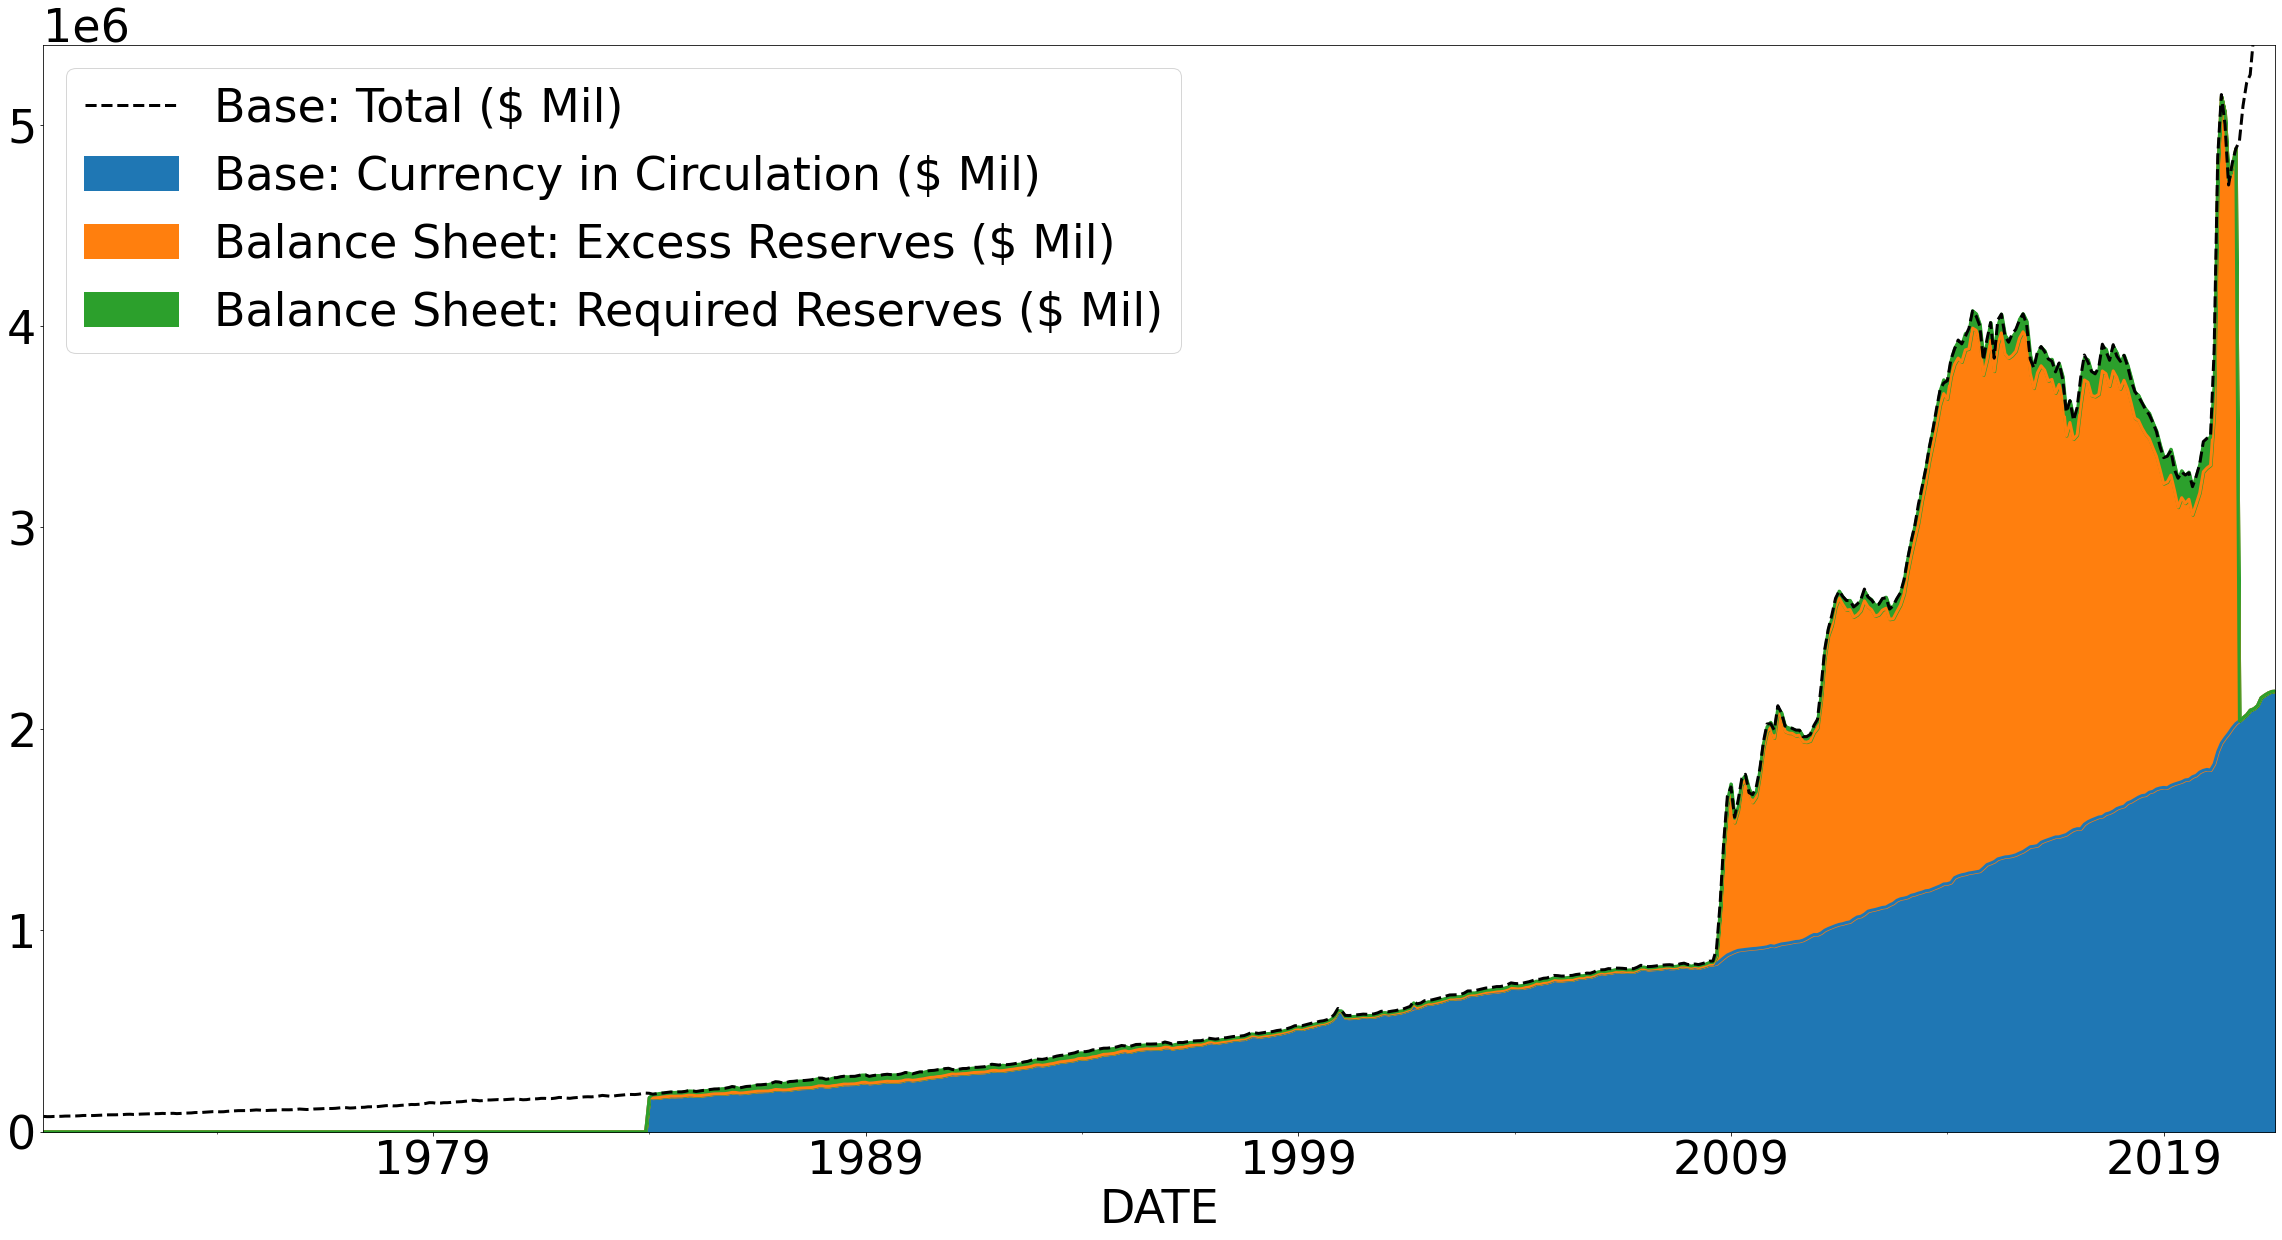

In [10]:
pp = PdfPages("stackedPlots.pdf")
money_vars = ["Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Excess Reserves ($ Mil)",
              "Balance Sheet: Required Reserves ($ Mil)"]

total_var = "Base: Total ($ Mil)"
plot_stacked_lines(data,
                  money_vars,
                  linewidth = 3,
                  total_var = total_var,
                  pp = pp)

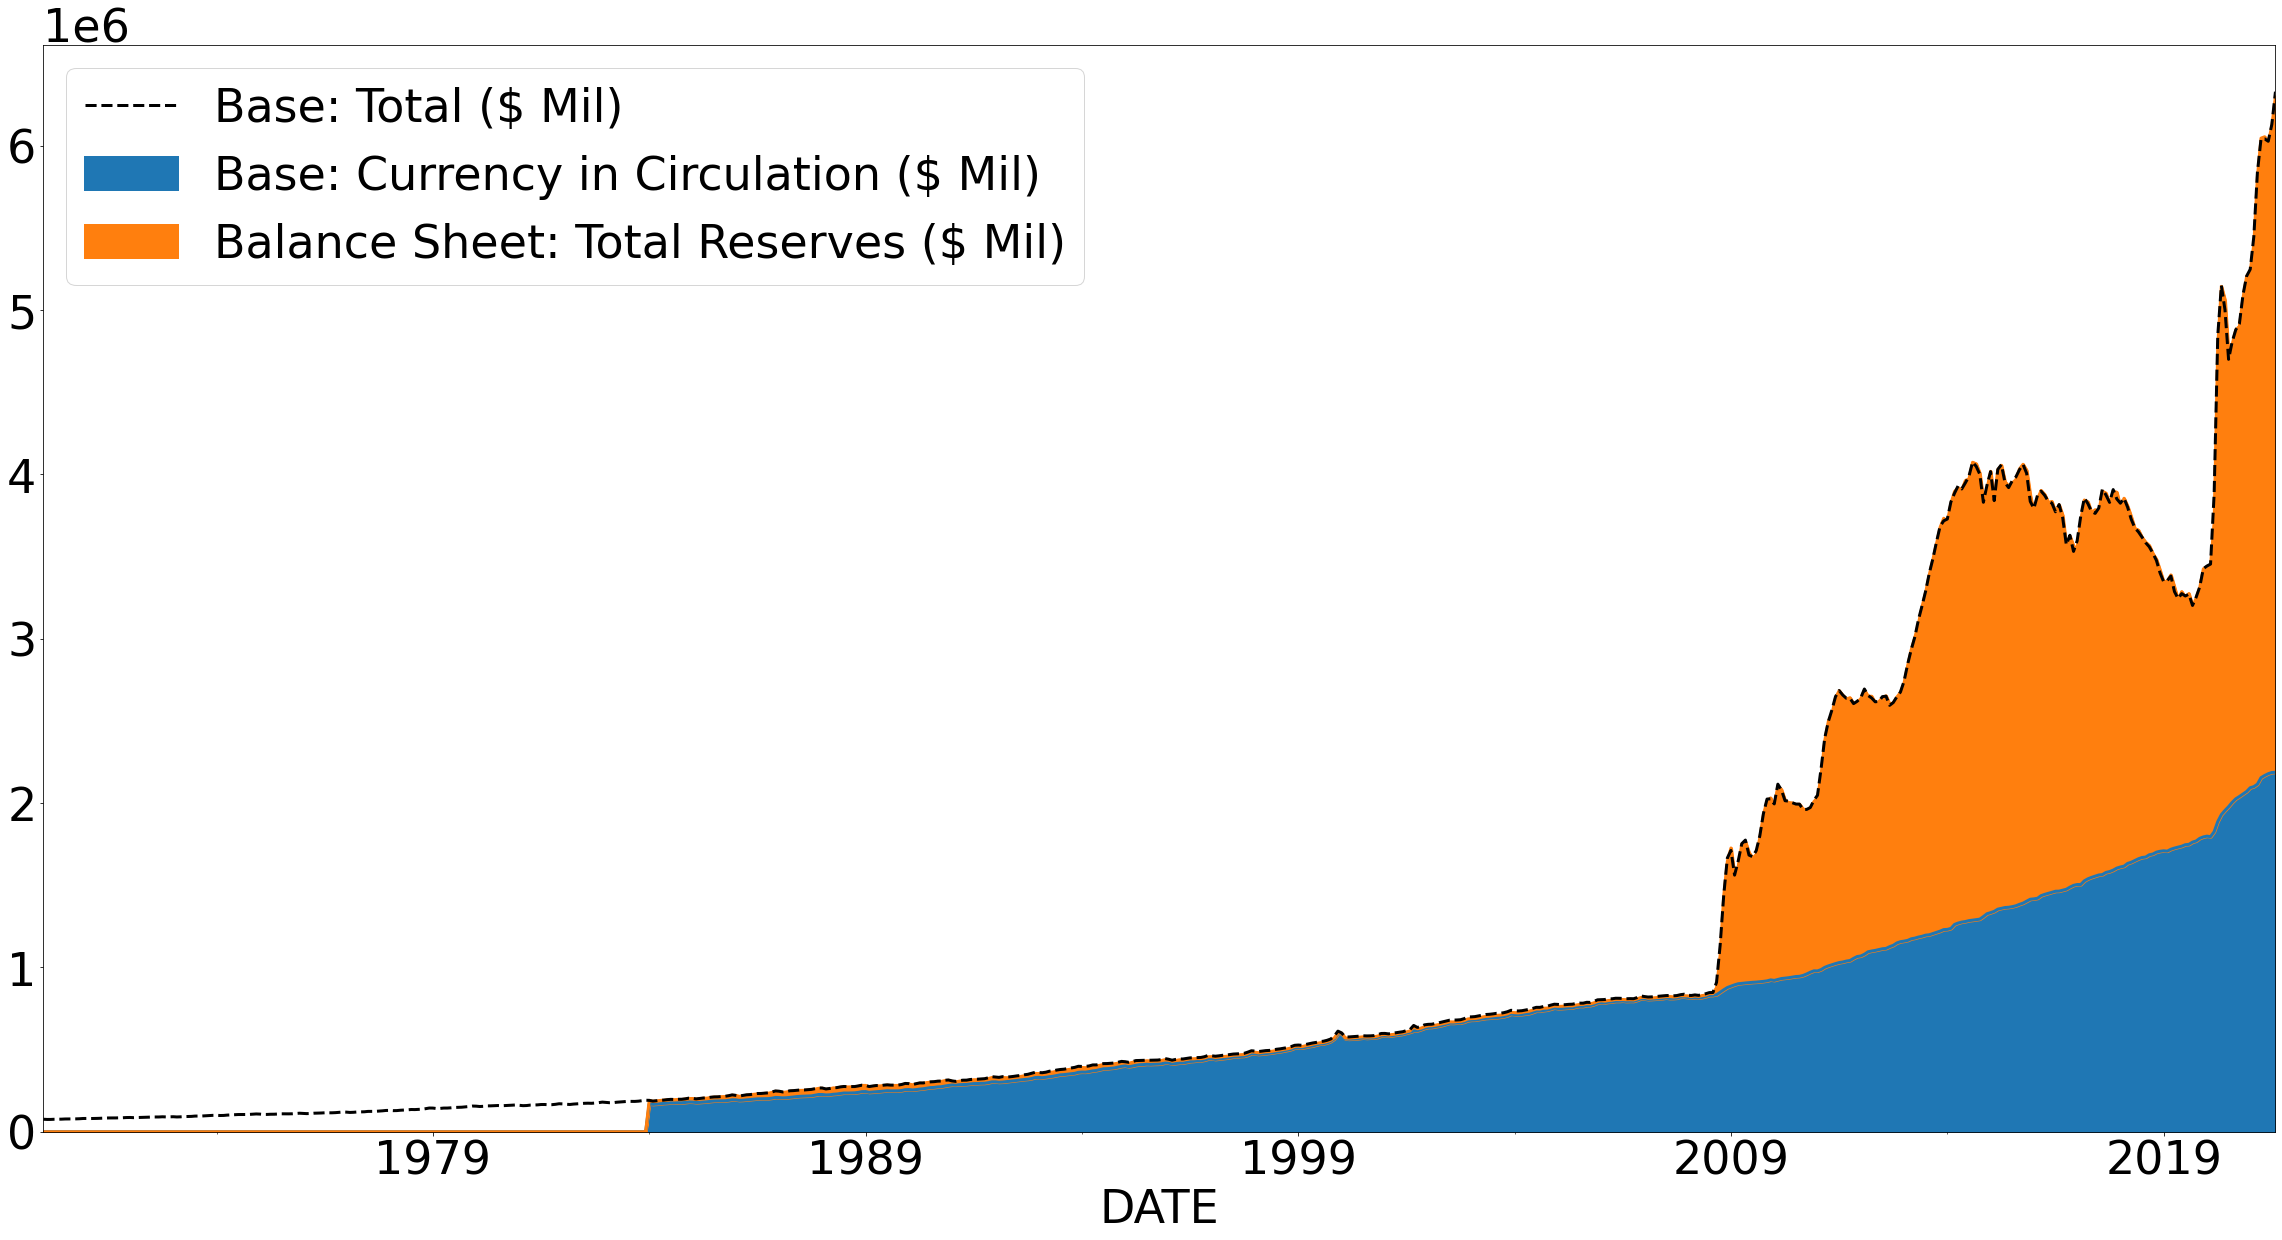

In [11]:
money_vars = ["Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Total Reserves ($ Mil)"]
total_var = "Base: Total ($ Mil)"
plot_stacked_lines(data,
                  money_vars,
                  linewidth = 3,
                  total_var = total_var,
                  pp = pp)

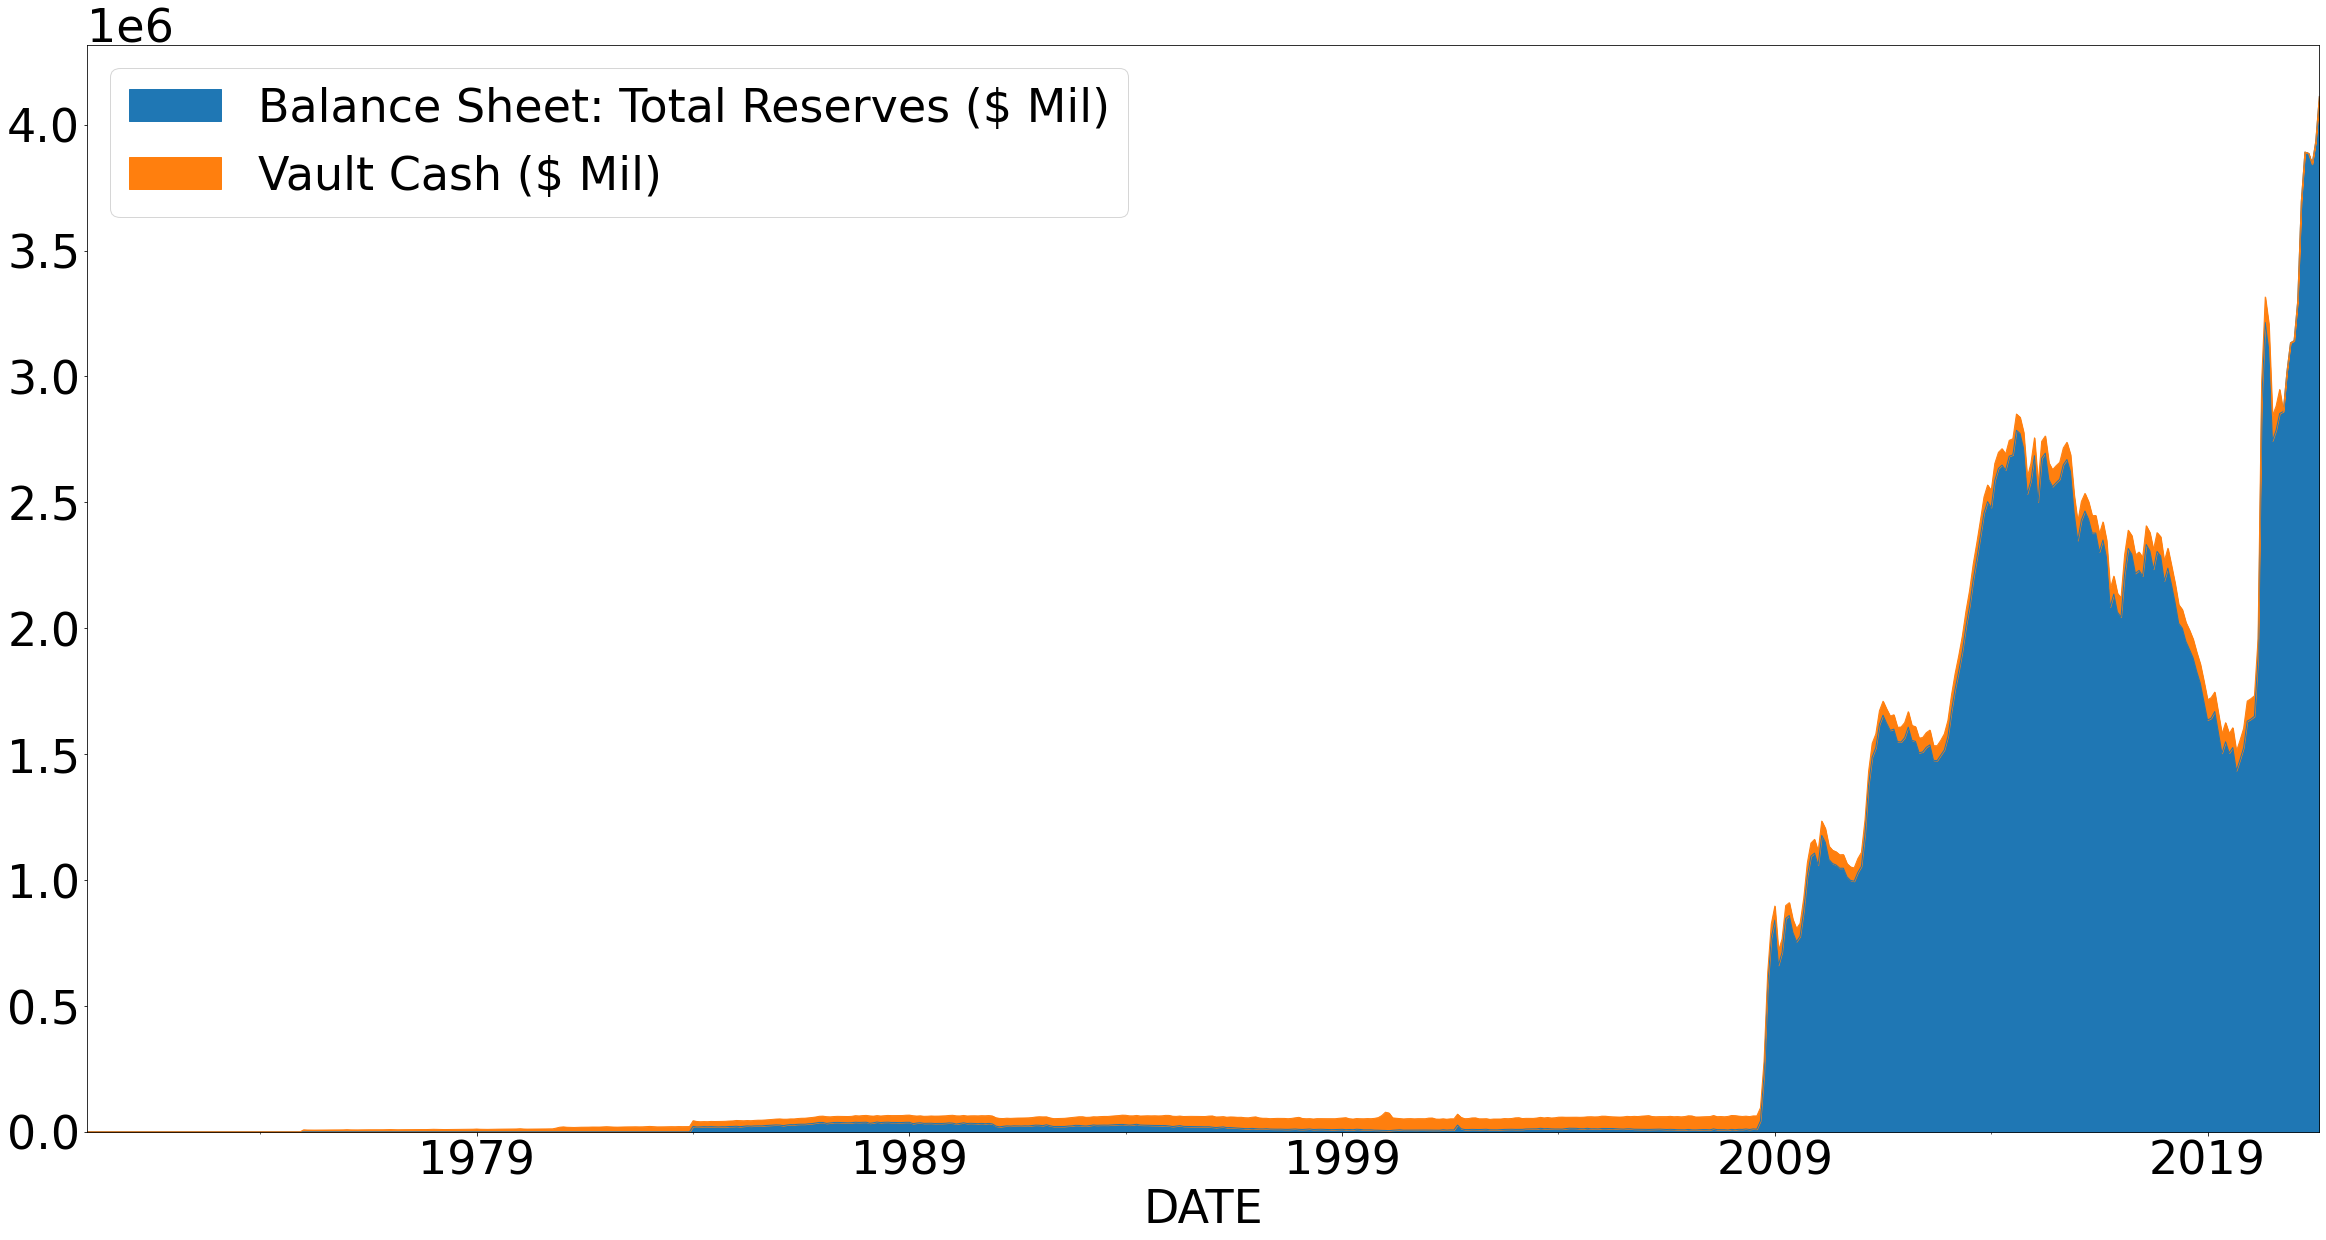

In [12]:
reserve_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Vault Cash ($ Mil)"]
plot_stacked_lines(data, 
                   reserve_vars, 
                   pp=pp)

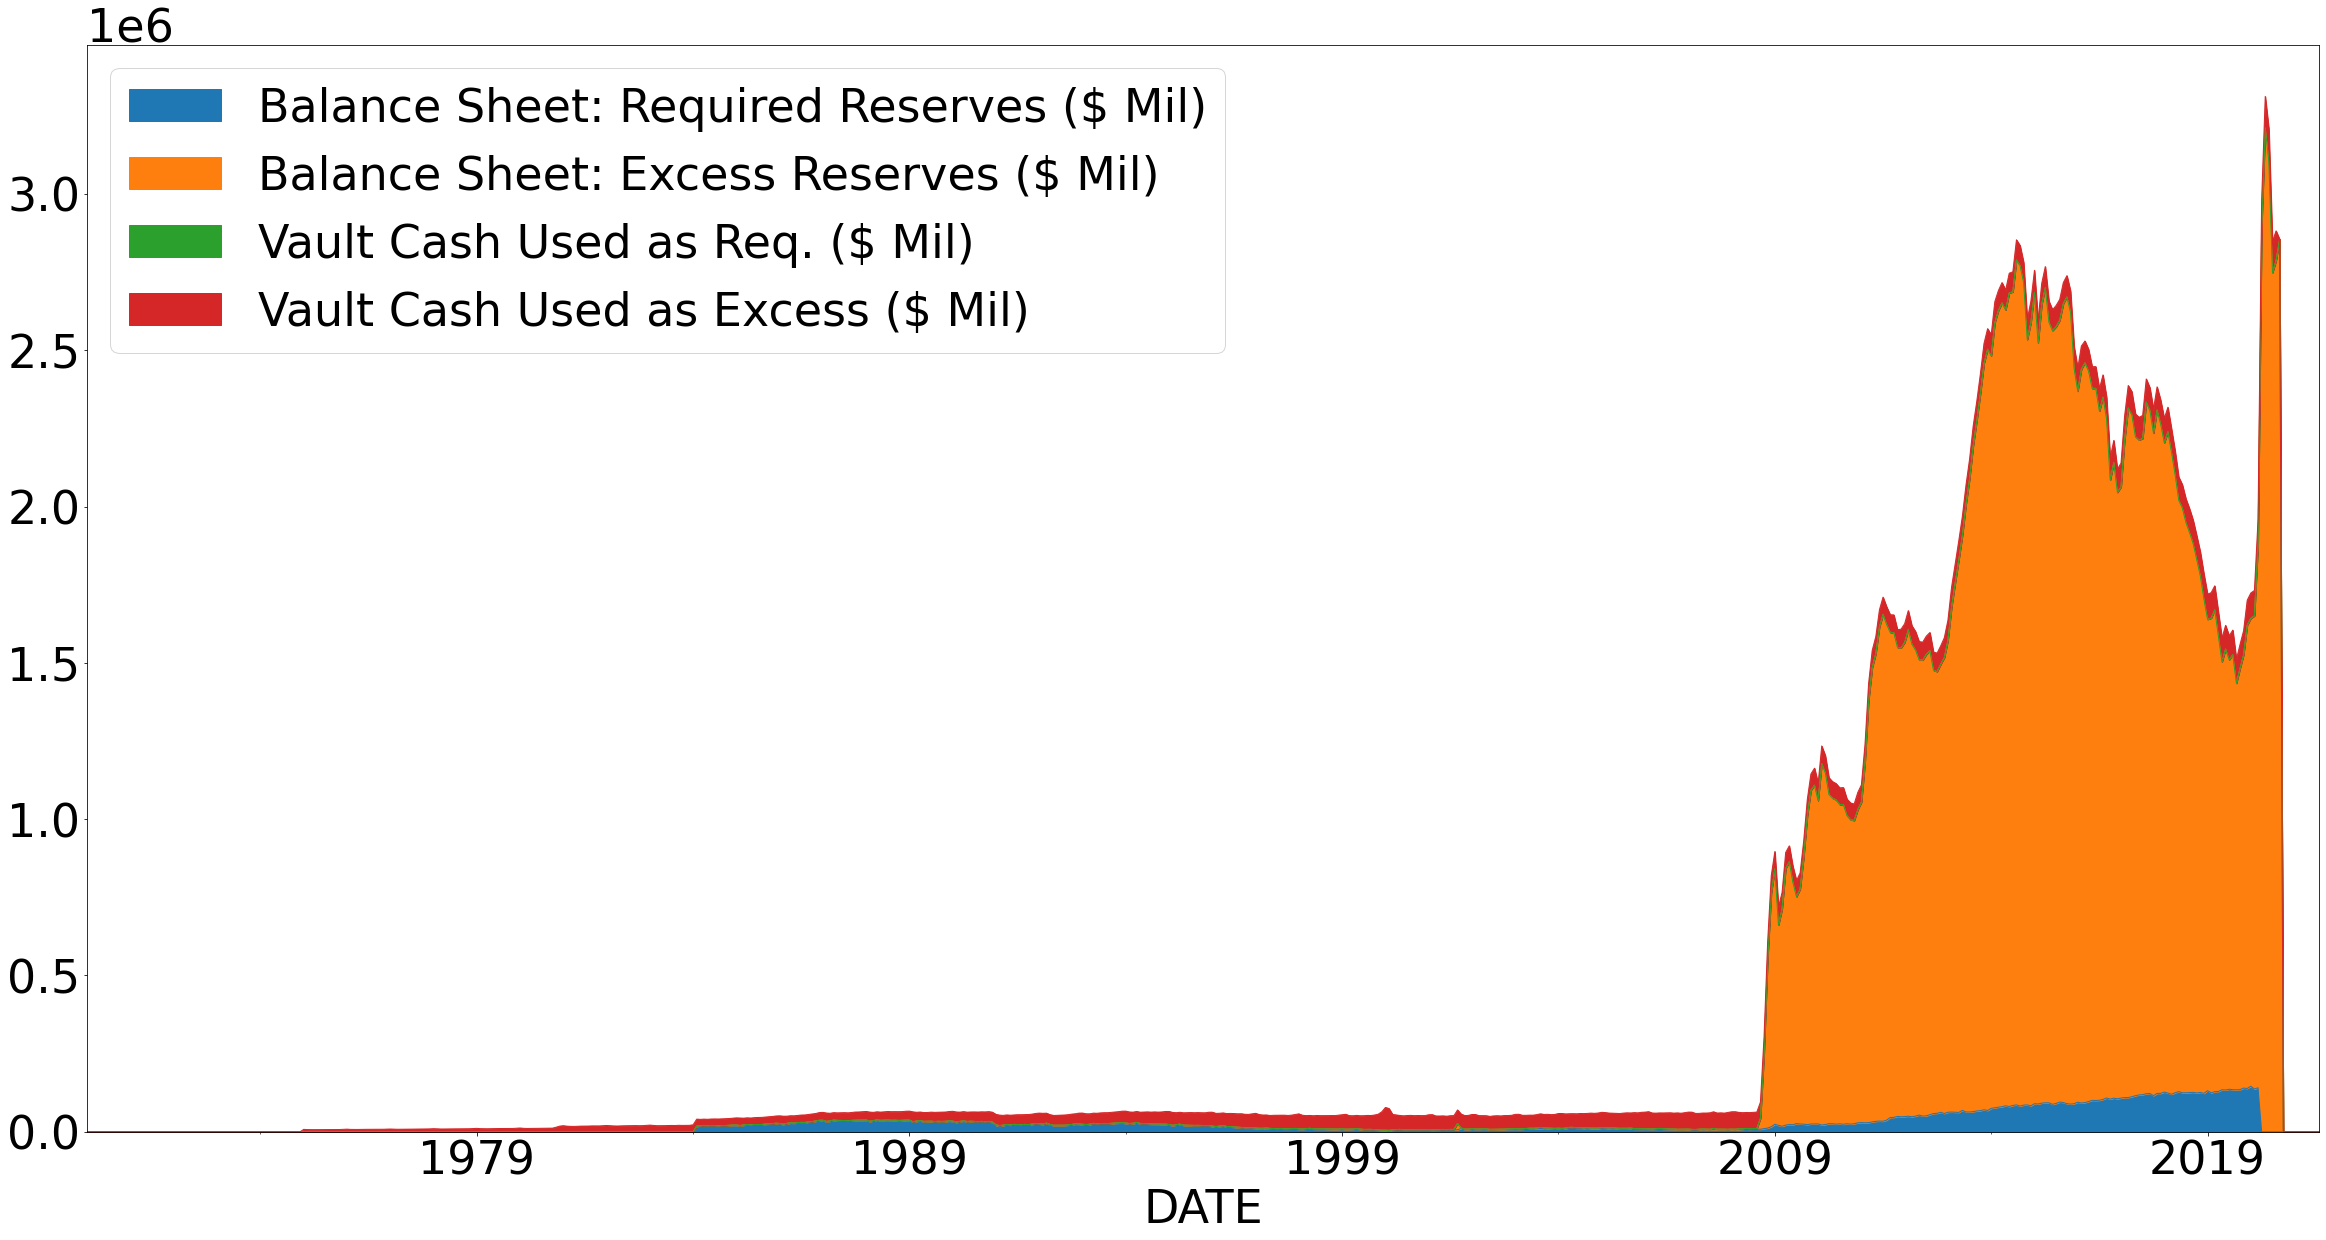

In [13]:
data["Vault Cash Used as Excess ($ Mil)"] = data["Vault Cash ($ Mil)"].sub(
    data["Vault Cash Used as Req. ($ Mil)"])

reserve_vars = ["Balance Sheet: Required Reserves ($ Mil)",
               "Balance Sheet: Excess Reserves ($ Mil)",
               "Vault Cash Used as Req. ($ Mil)",
               "Vault Cash Used as Excess ($ Mil)"]
plot_stacked_lines(data, reserve_vars, pp =pp)

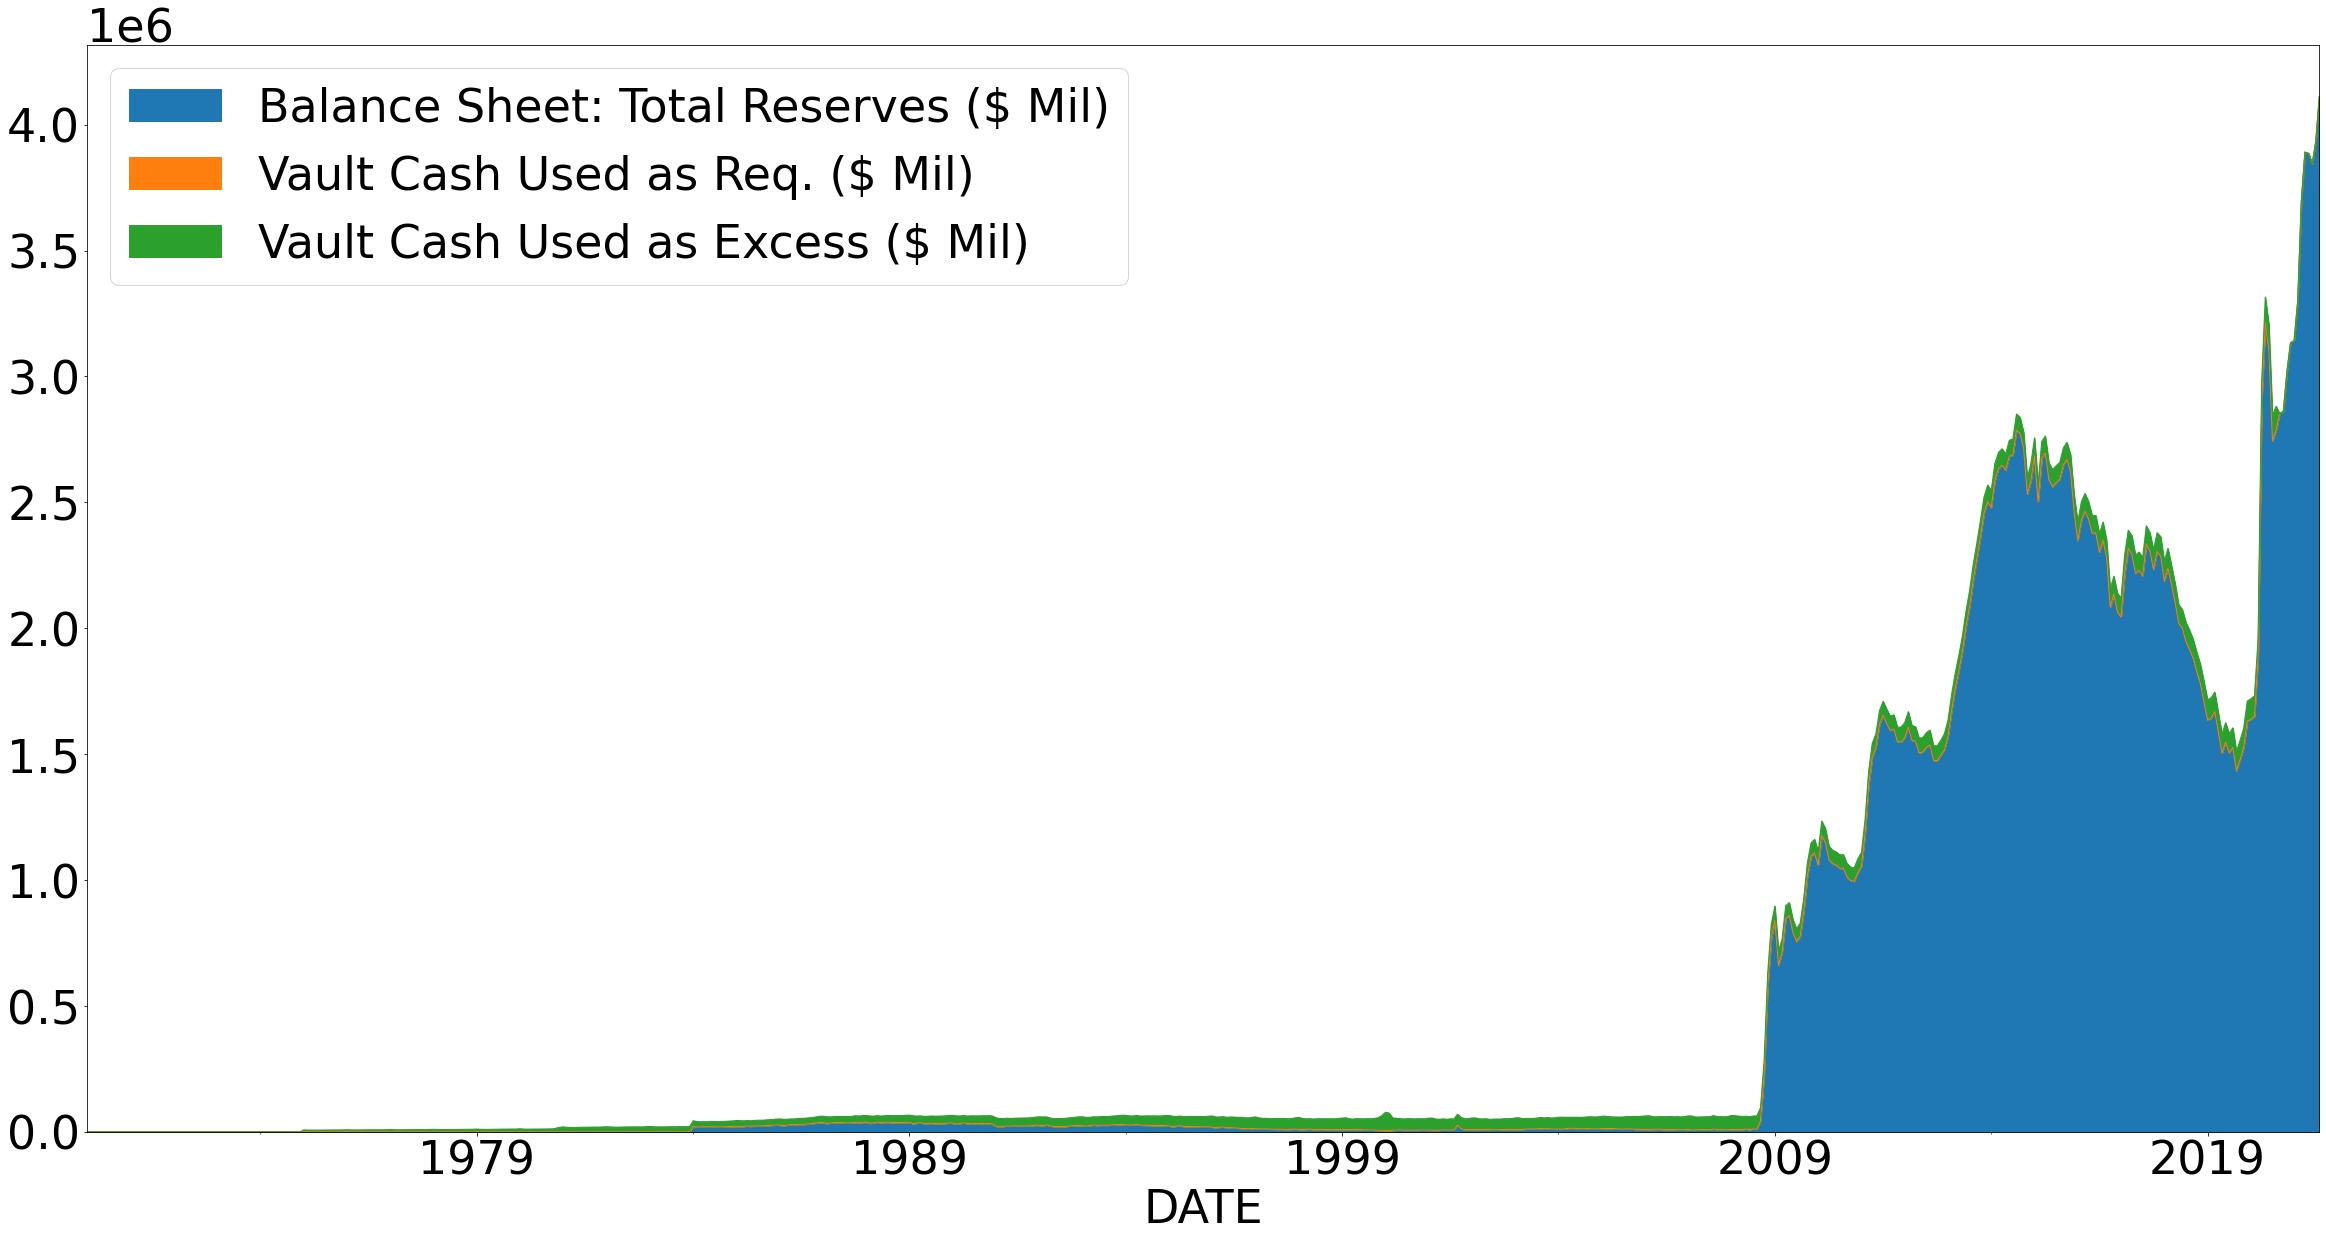

In [14]:
reserve_vars = ["Balance Sheet: Total Reserves ($ Mil)",
               "Vault Cash Used as Req. ($ Mil)",
               "Vault Cash Used as Excess ($ Mil)"]
plot_stacked_lines(data, reserve_vars, pp =pp)

## Federal Reserve Assets

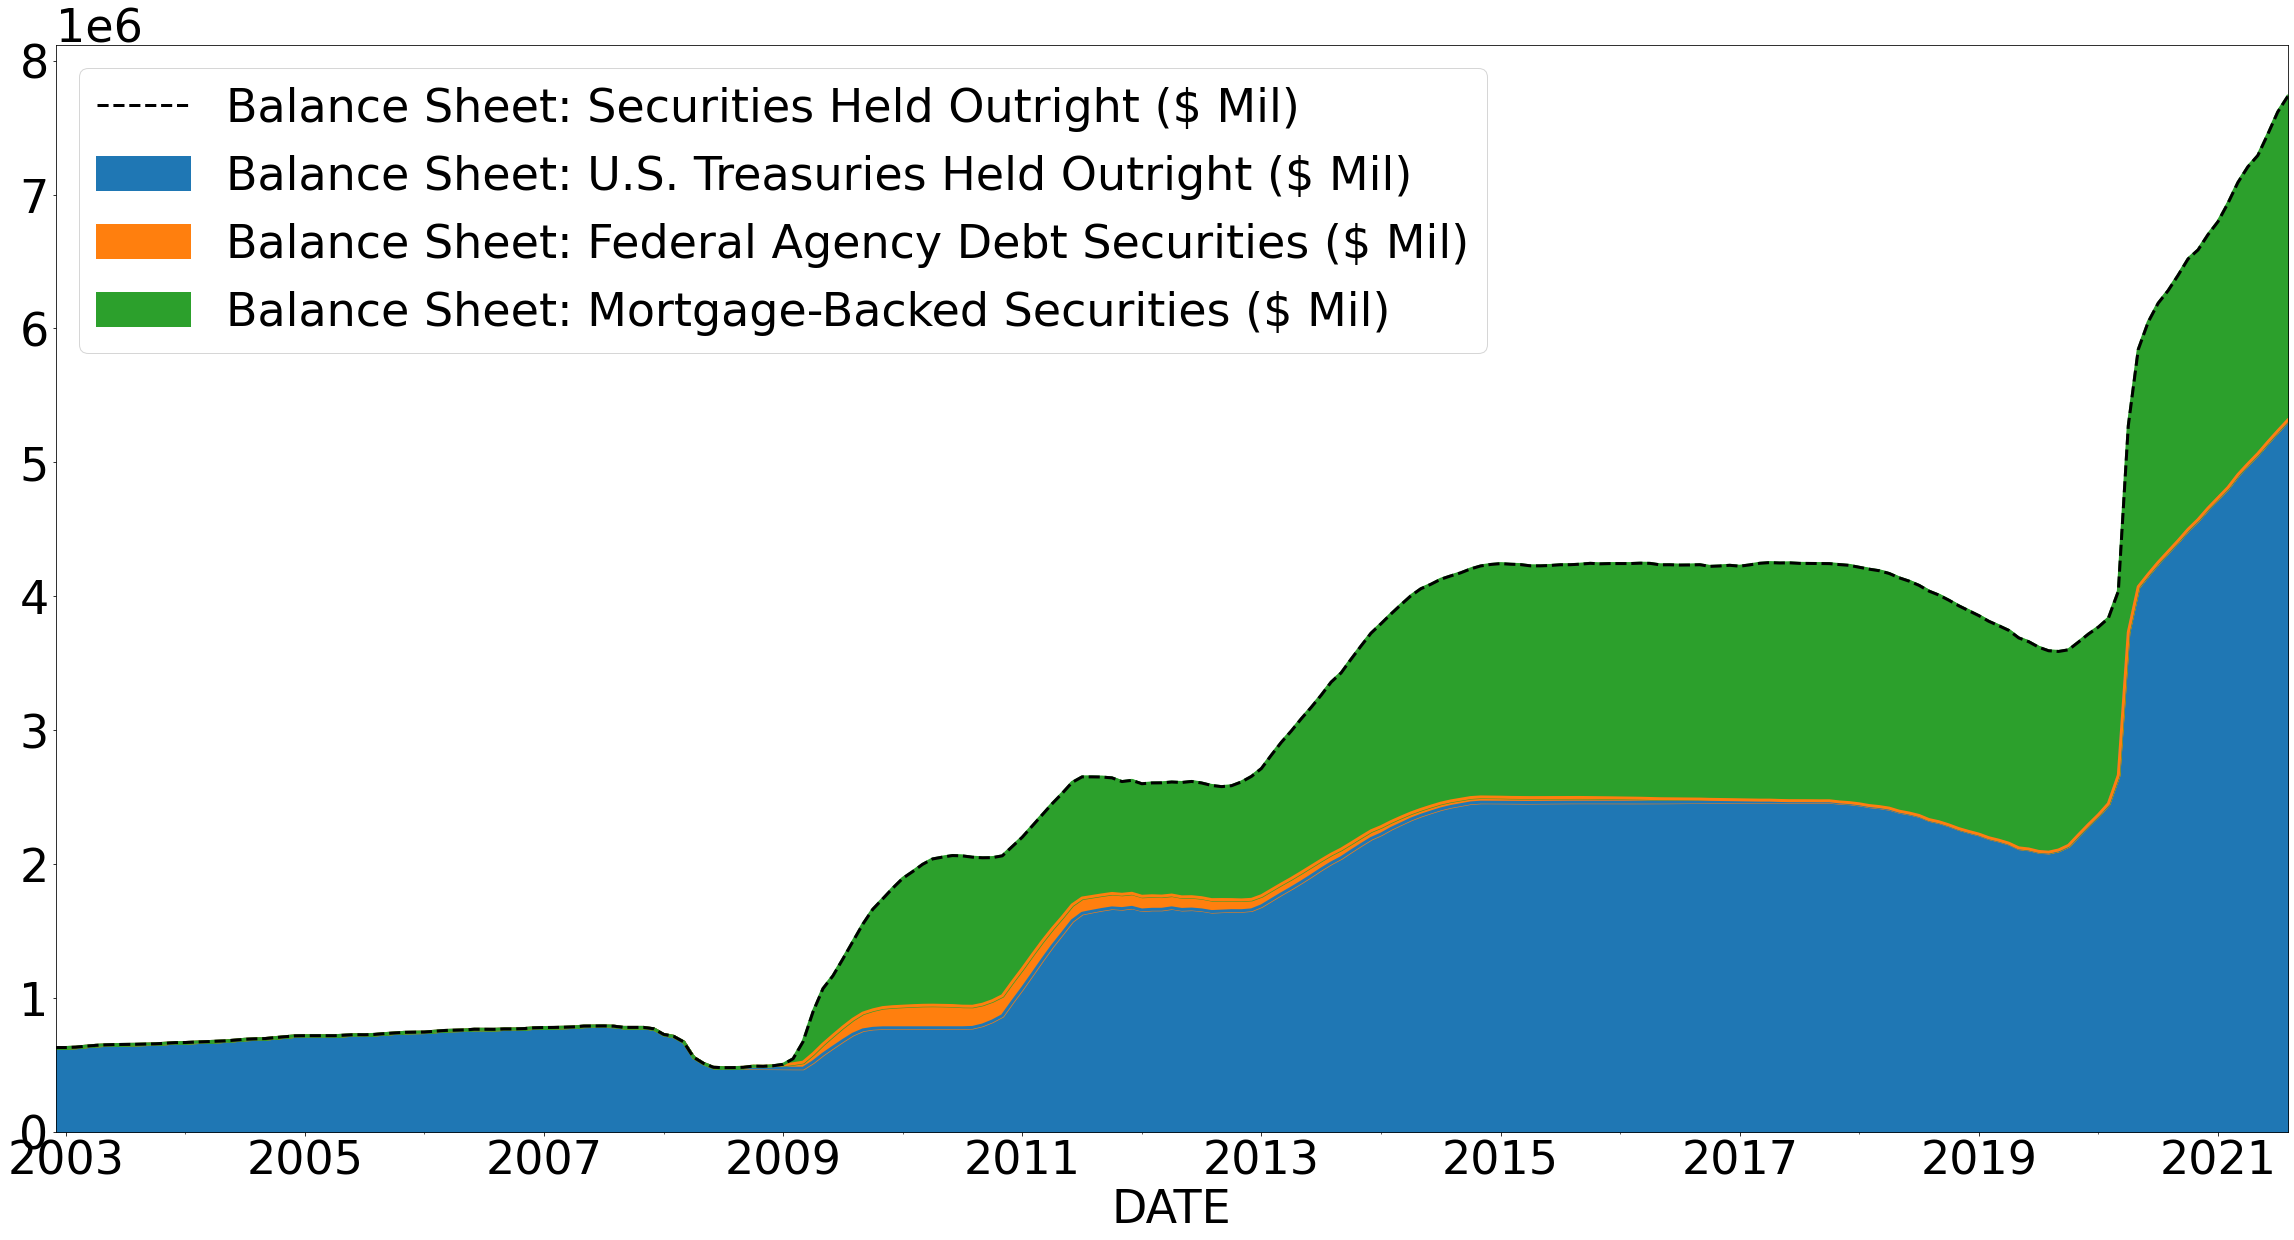

In [15]:
asset_vars = ["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)",
              "Balance Sheet: Federal Agency Debt Securities ($ Mil)",
              "Balance Sheet: Mortgage-Backed Securities ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":], asset_vars, linewidth = 3,
                  total_var = "Balance Sheet: Securities Held Outright ($ Mil)",
                  pp = pp)

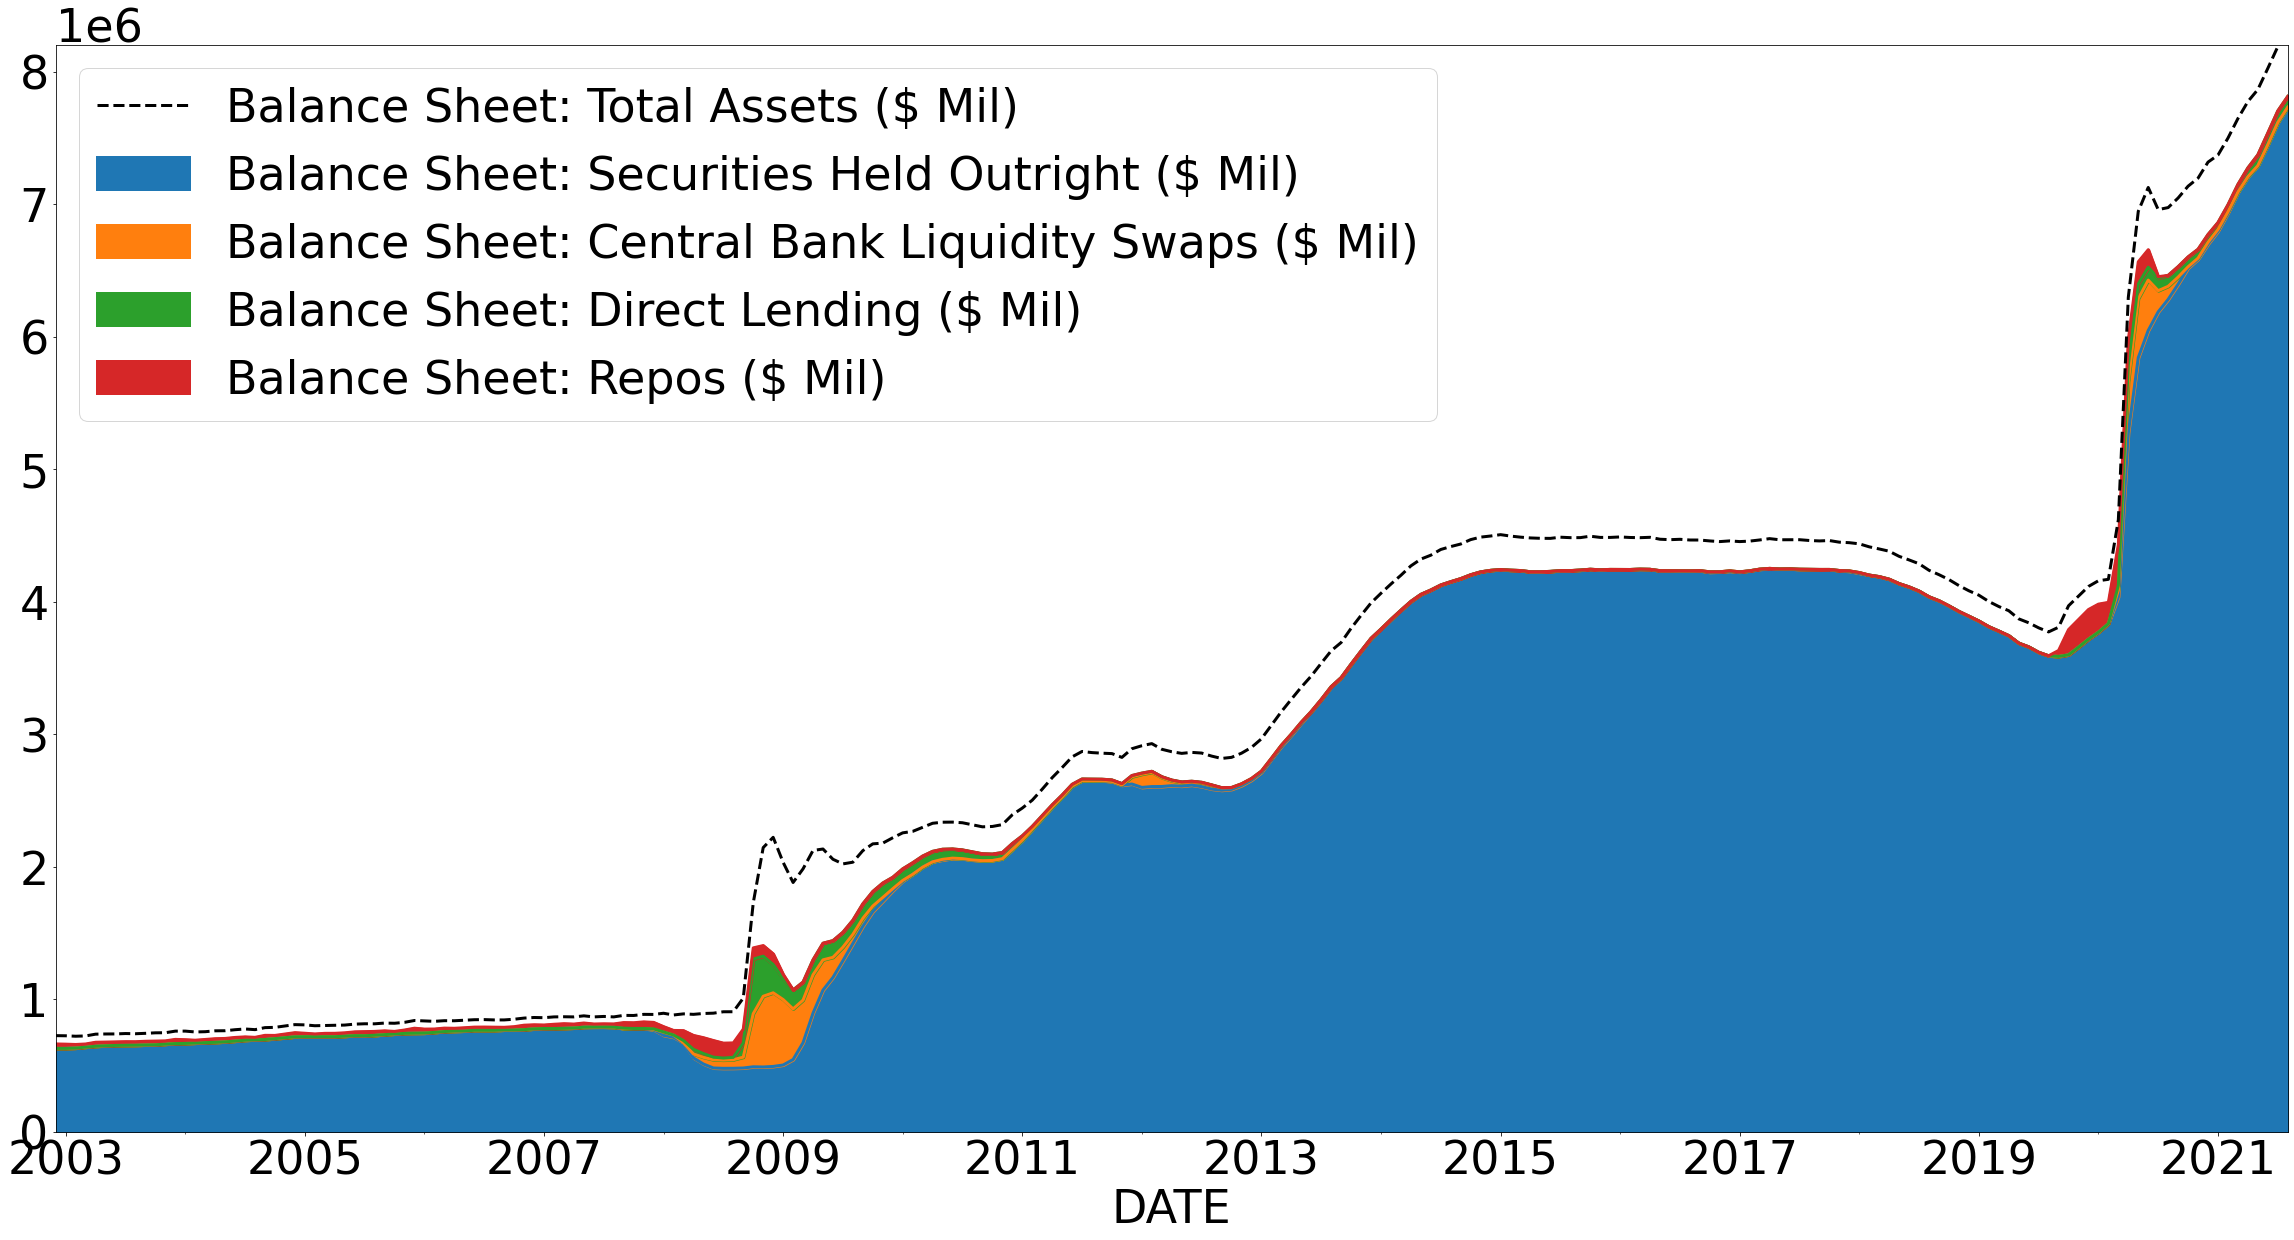

In [16]:
asset_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
               "Balance Sheet: Direct Lending ($ Mil)",
               "Balance Sheet: Repos ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":],
                  asset_vars,
                  linewidth = 3,
                  total_var = "Balance Sheet: Total Assets ($ Mil)",
                  pp = pp)

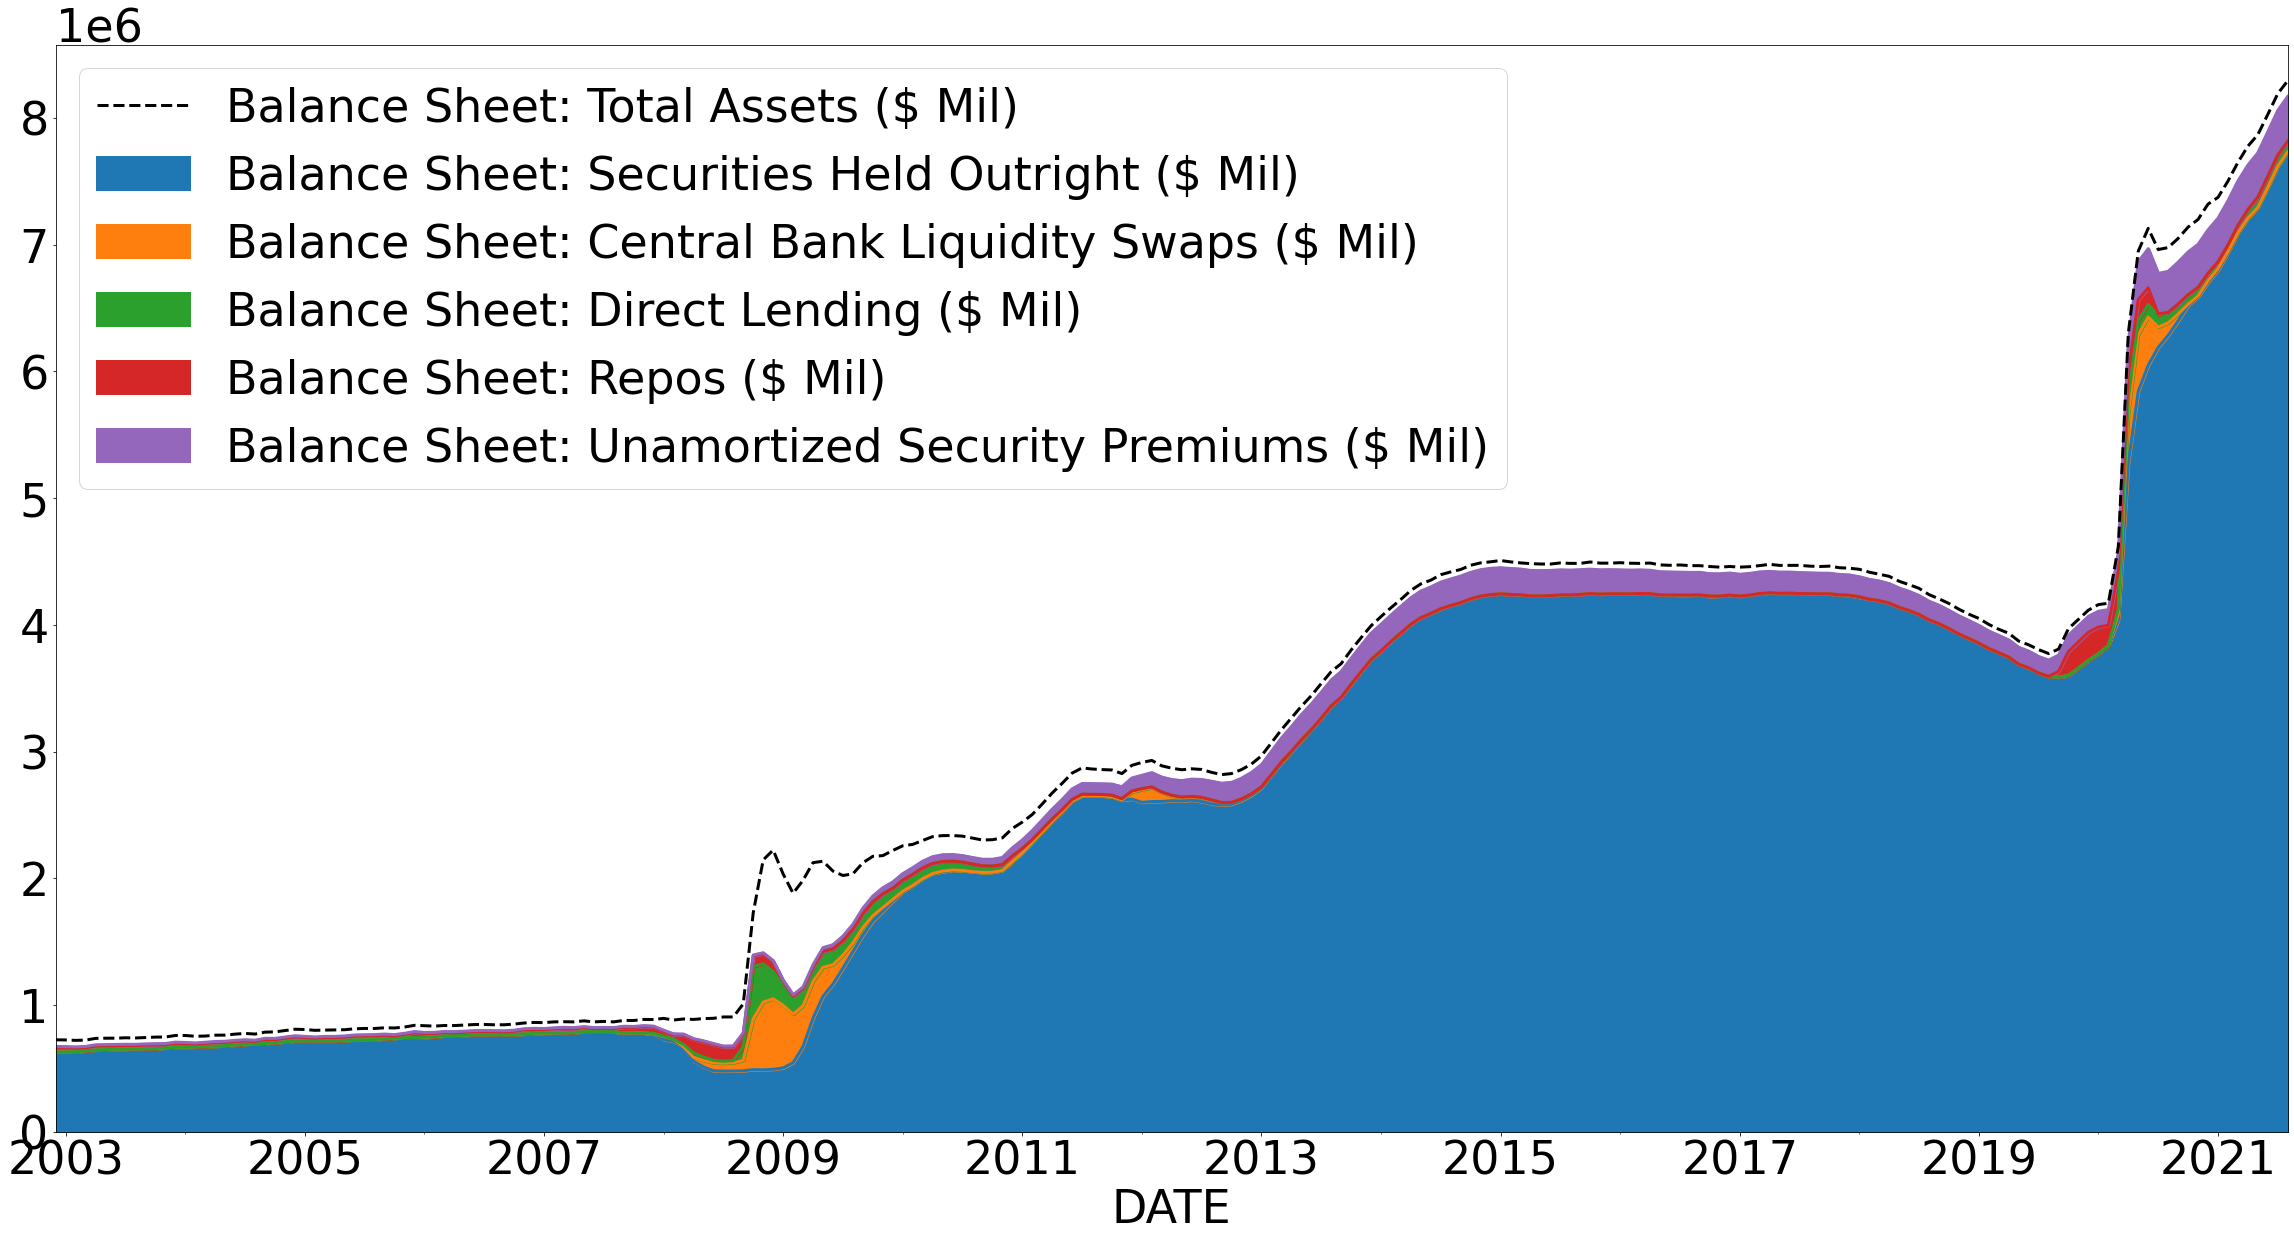

In [17]:
asset_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
               "Balance Sheet: Direct Lending ($ Mil)",
               "Balance Sheet: Repos ($ Mil)",
               "Balance Sheet: Unamortized Security Premiums ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":],
                  asset_vars,
                  linewidth = 3,
                  total_var = "Balance Sheet: Total Assets ($ Mil)",
                  pp = pp)

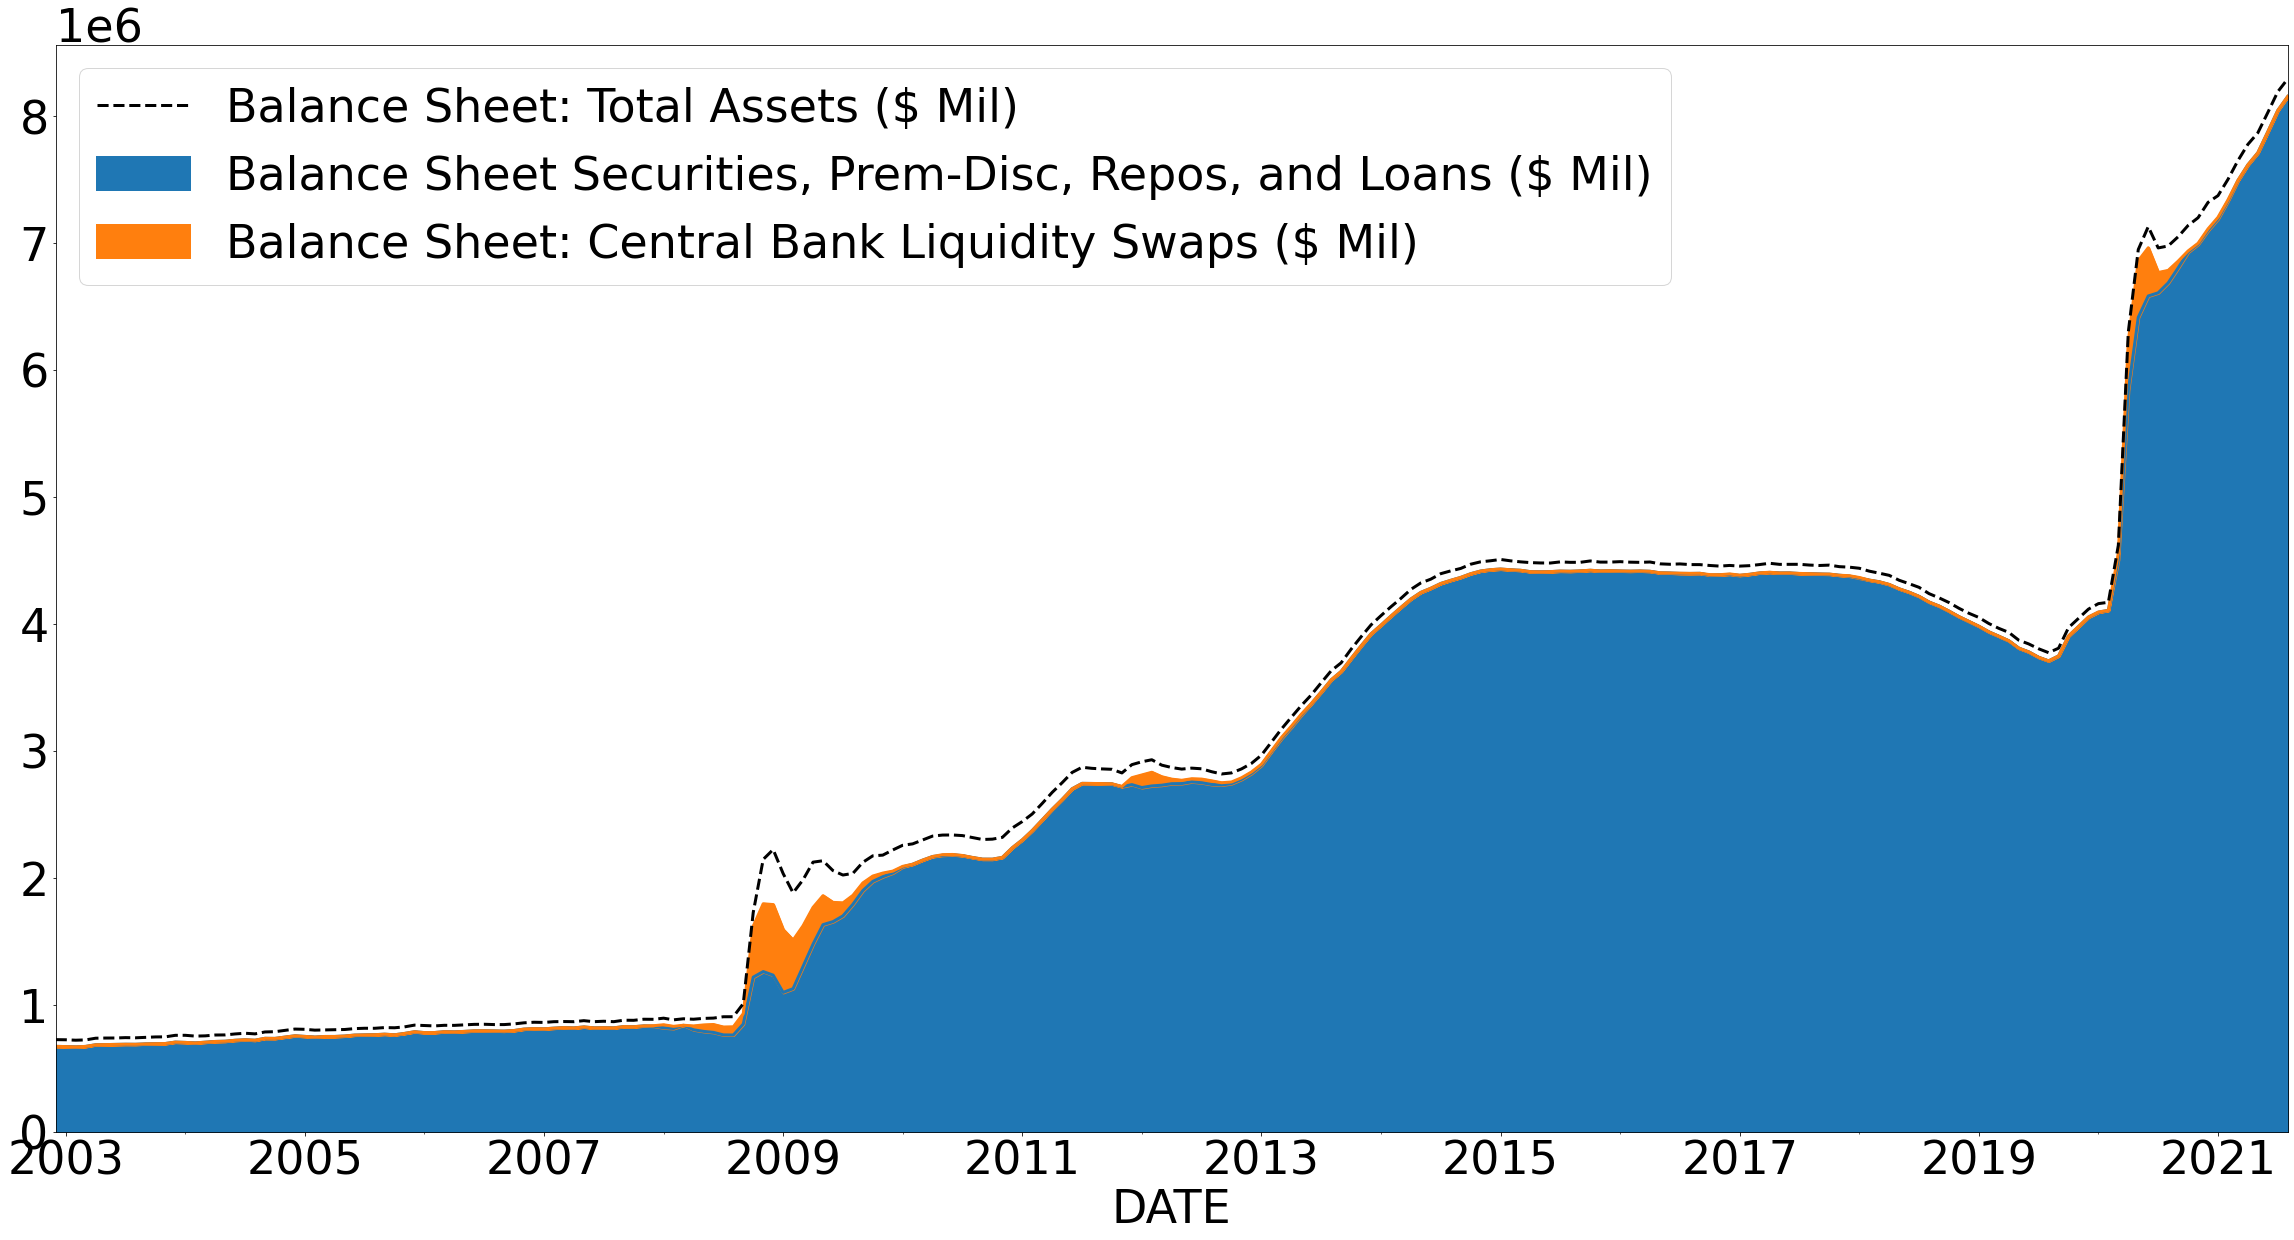

In [18]:
account_vars = ["Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",
                "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":], account_vars, linewidth = 3, total_var = "Balance Sheet: Total Assets ($ Mil)",
                  pp = pp)

## Liabilities 

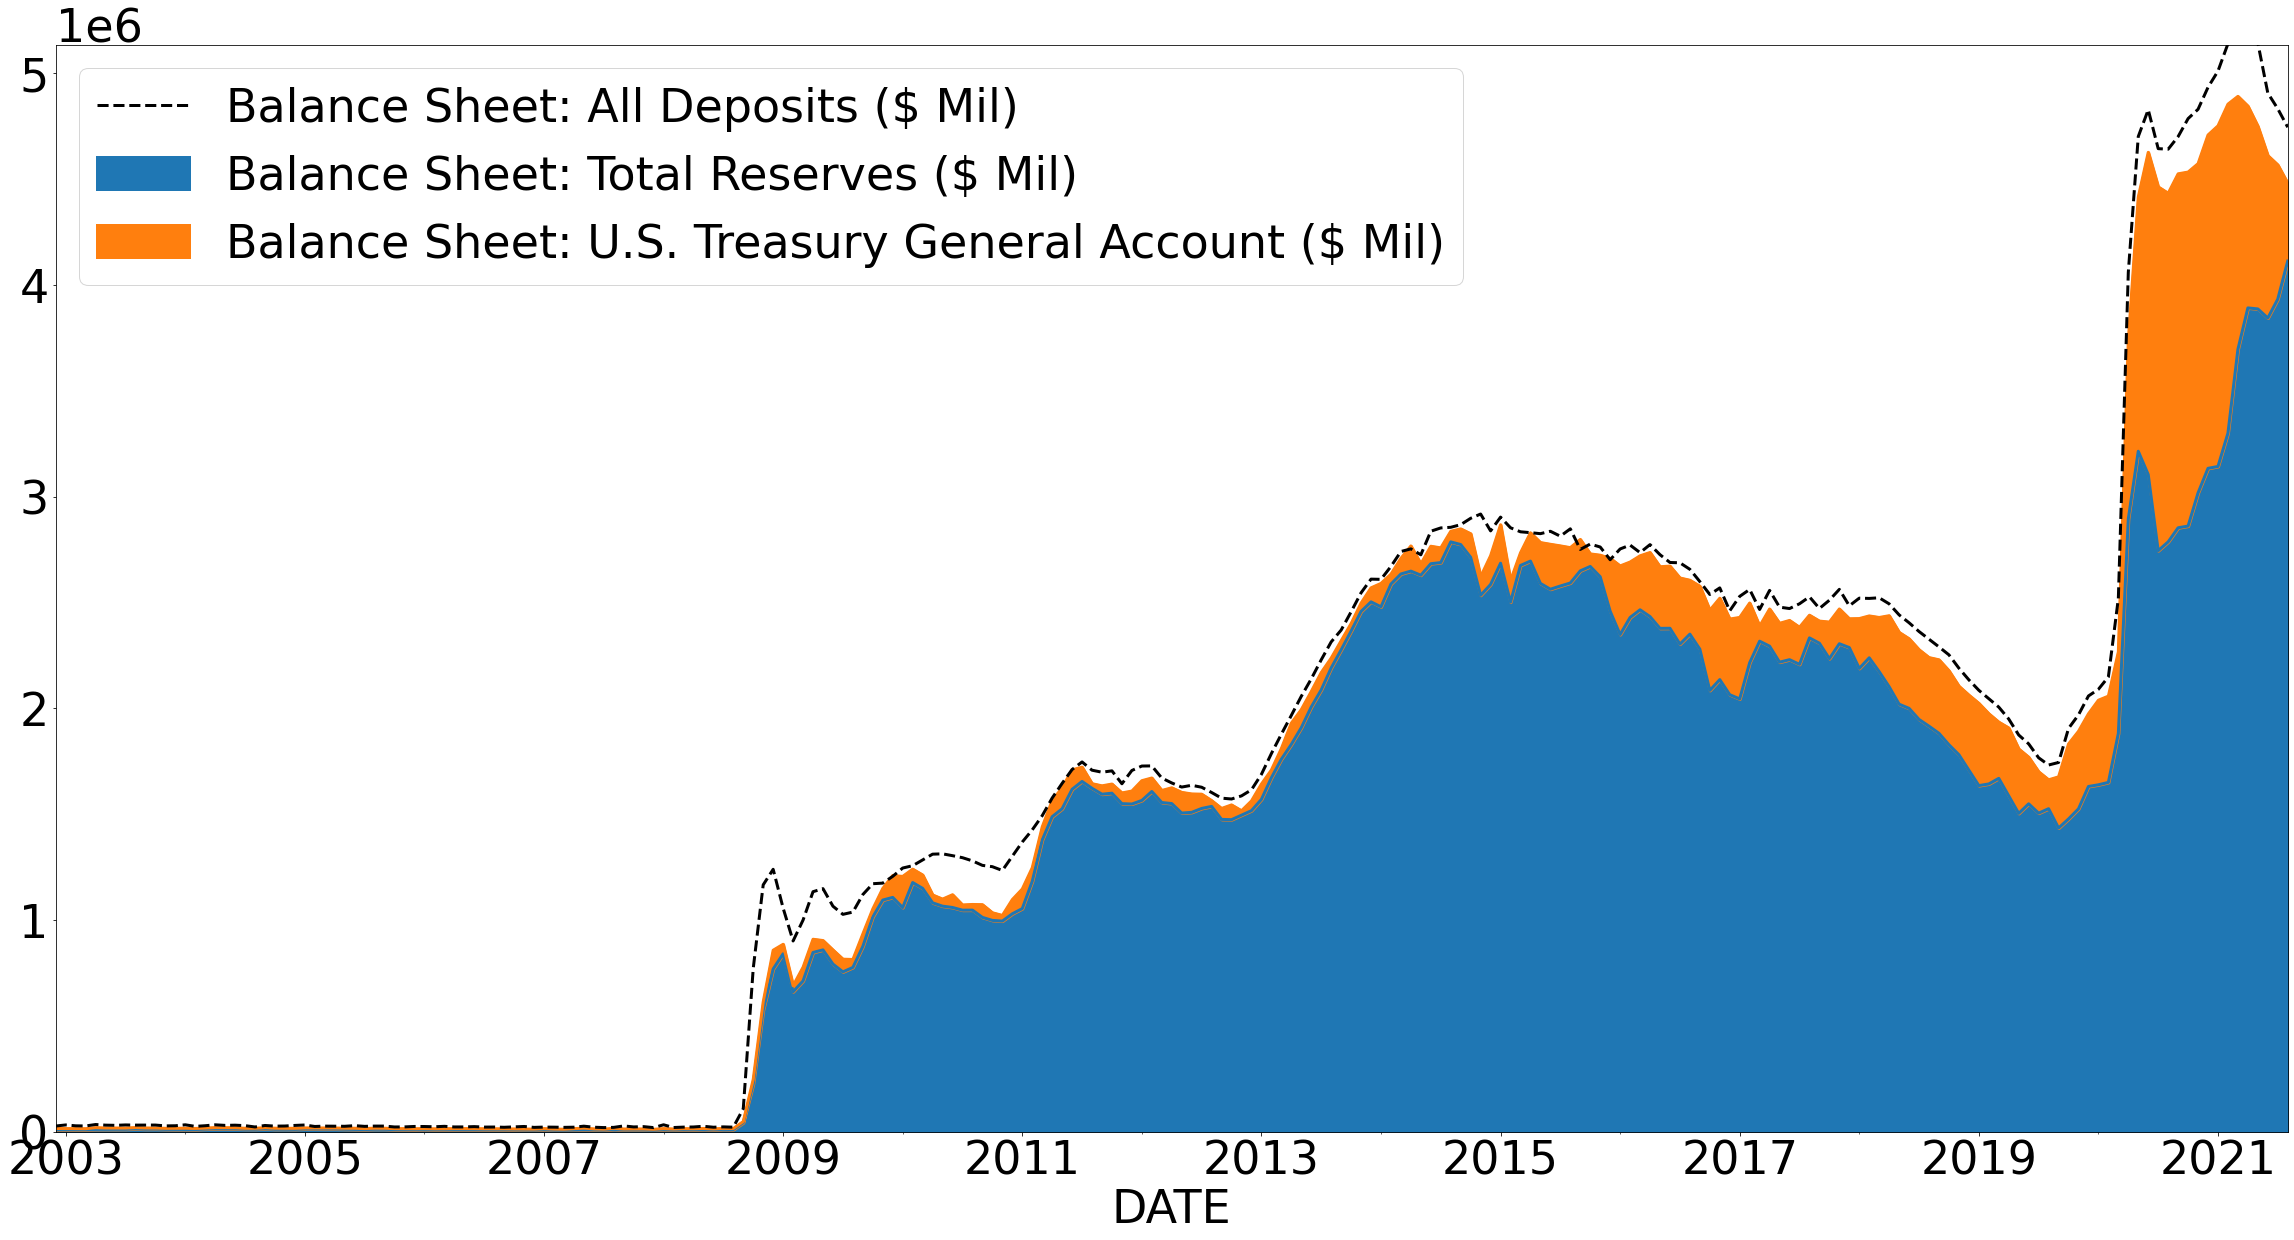

In [19]:
account_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Balance Sheet: U.S. Treasury General Account ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":], account_vars, linewidth = 3, total_var = "Balance Sheet: All Deposits ($ Mil)",
                  pp = pp)

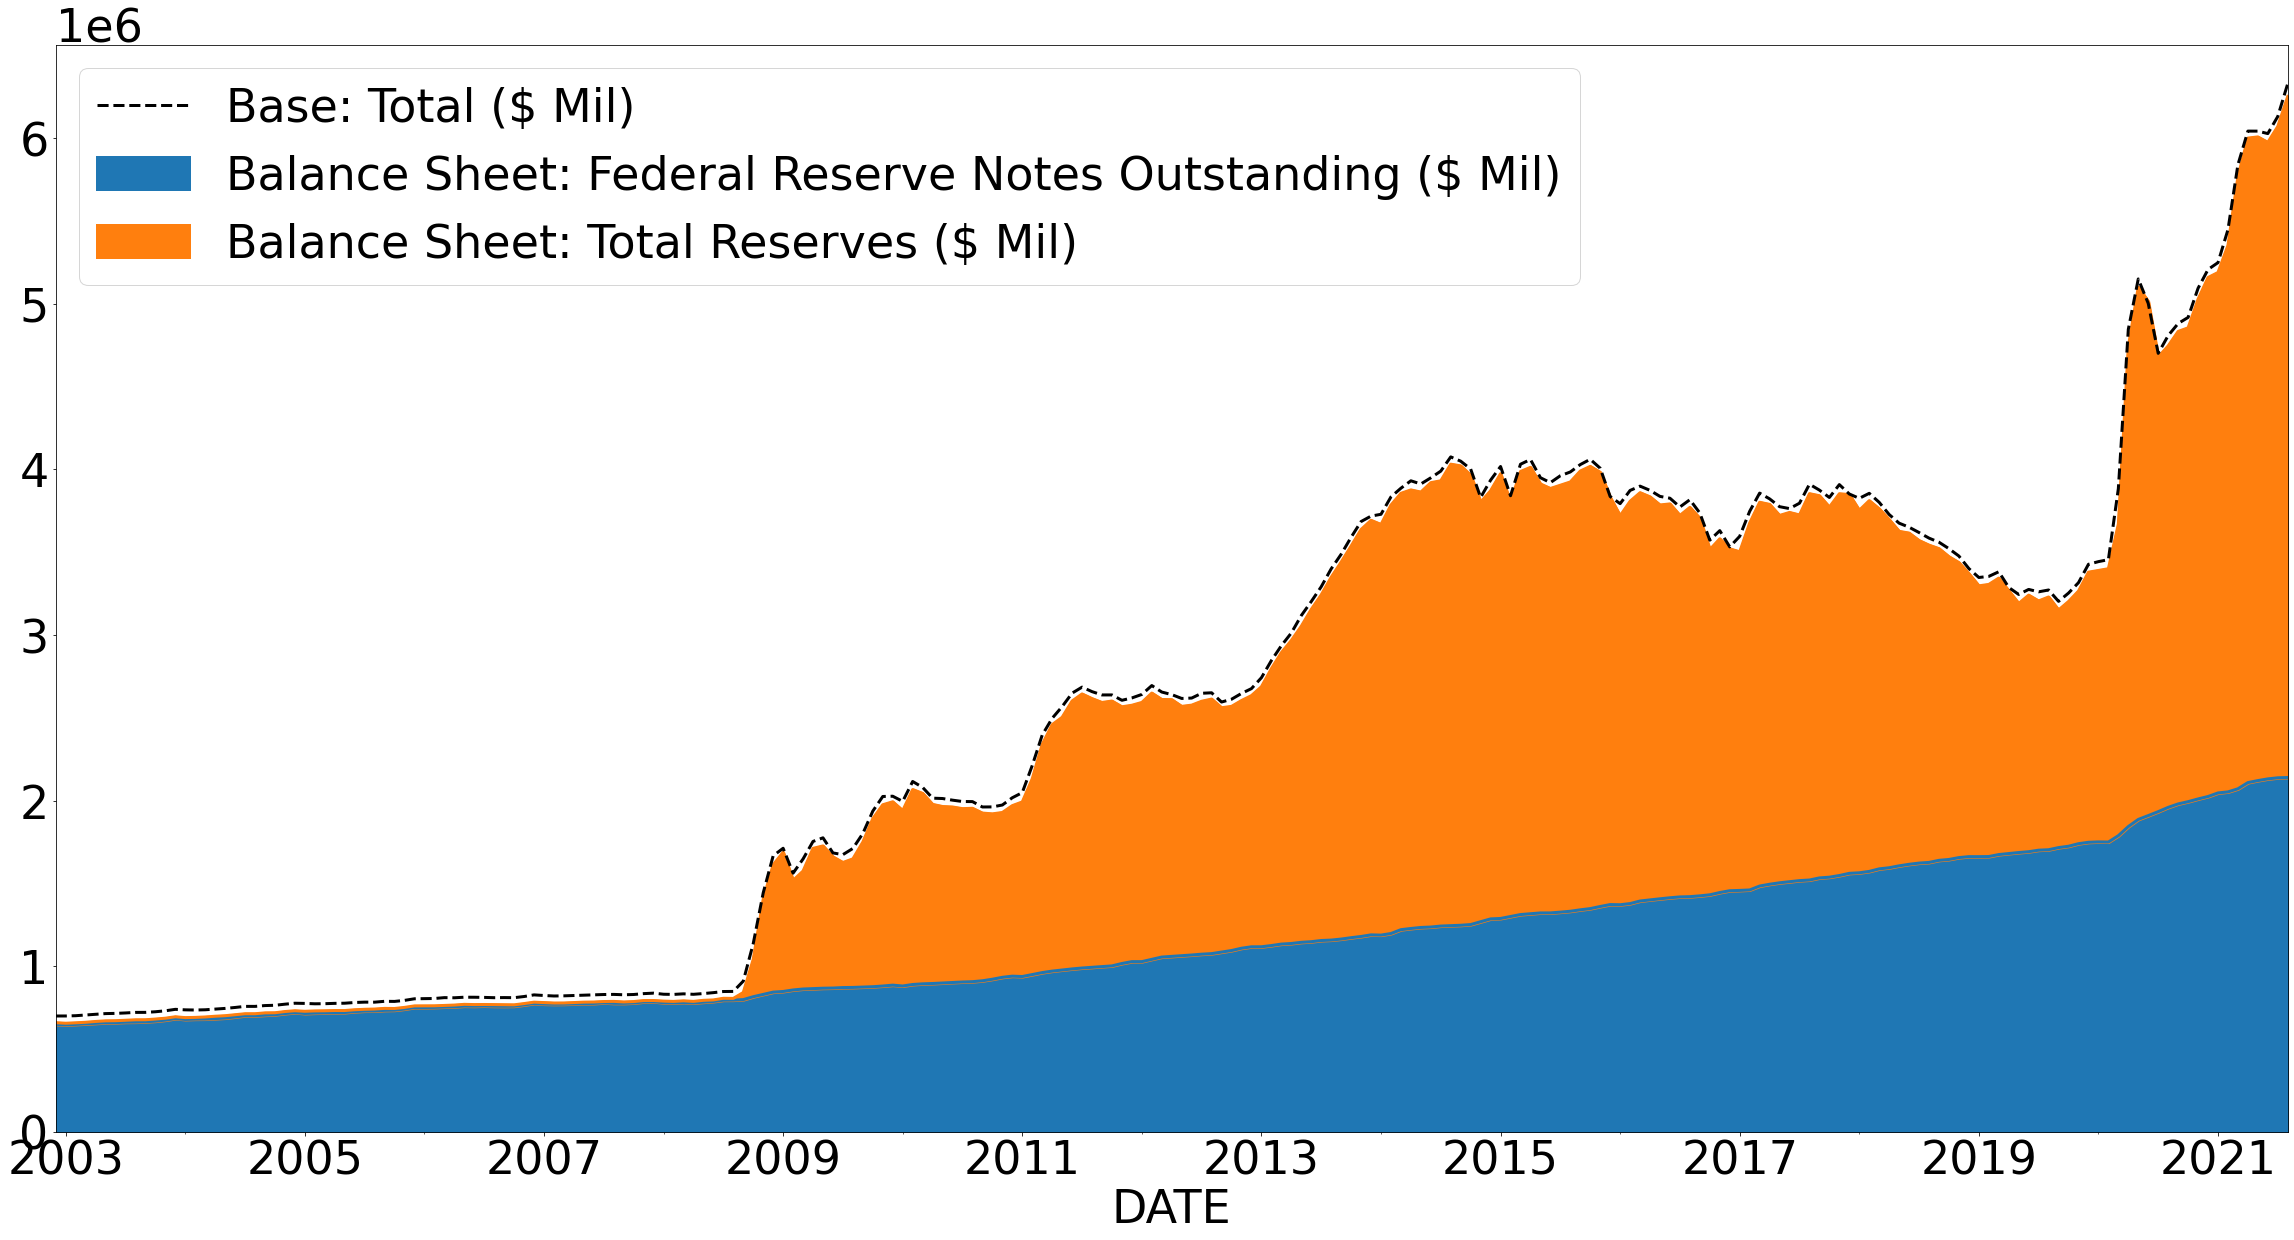

In [20]:
account_vars = ["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)",
                "Balance Sheet: Total Reserves ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":], account_vars, linewidth = 3, total_var = "Base: Total ($ Mil)",
                  pp = pp)

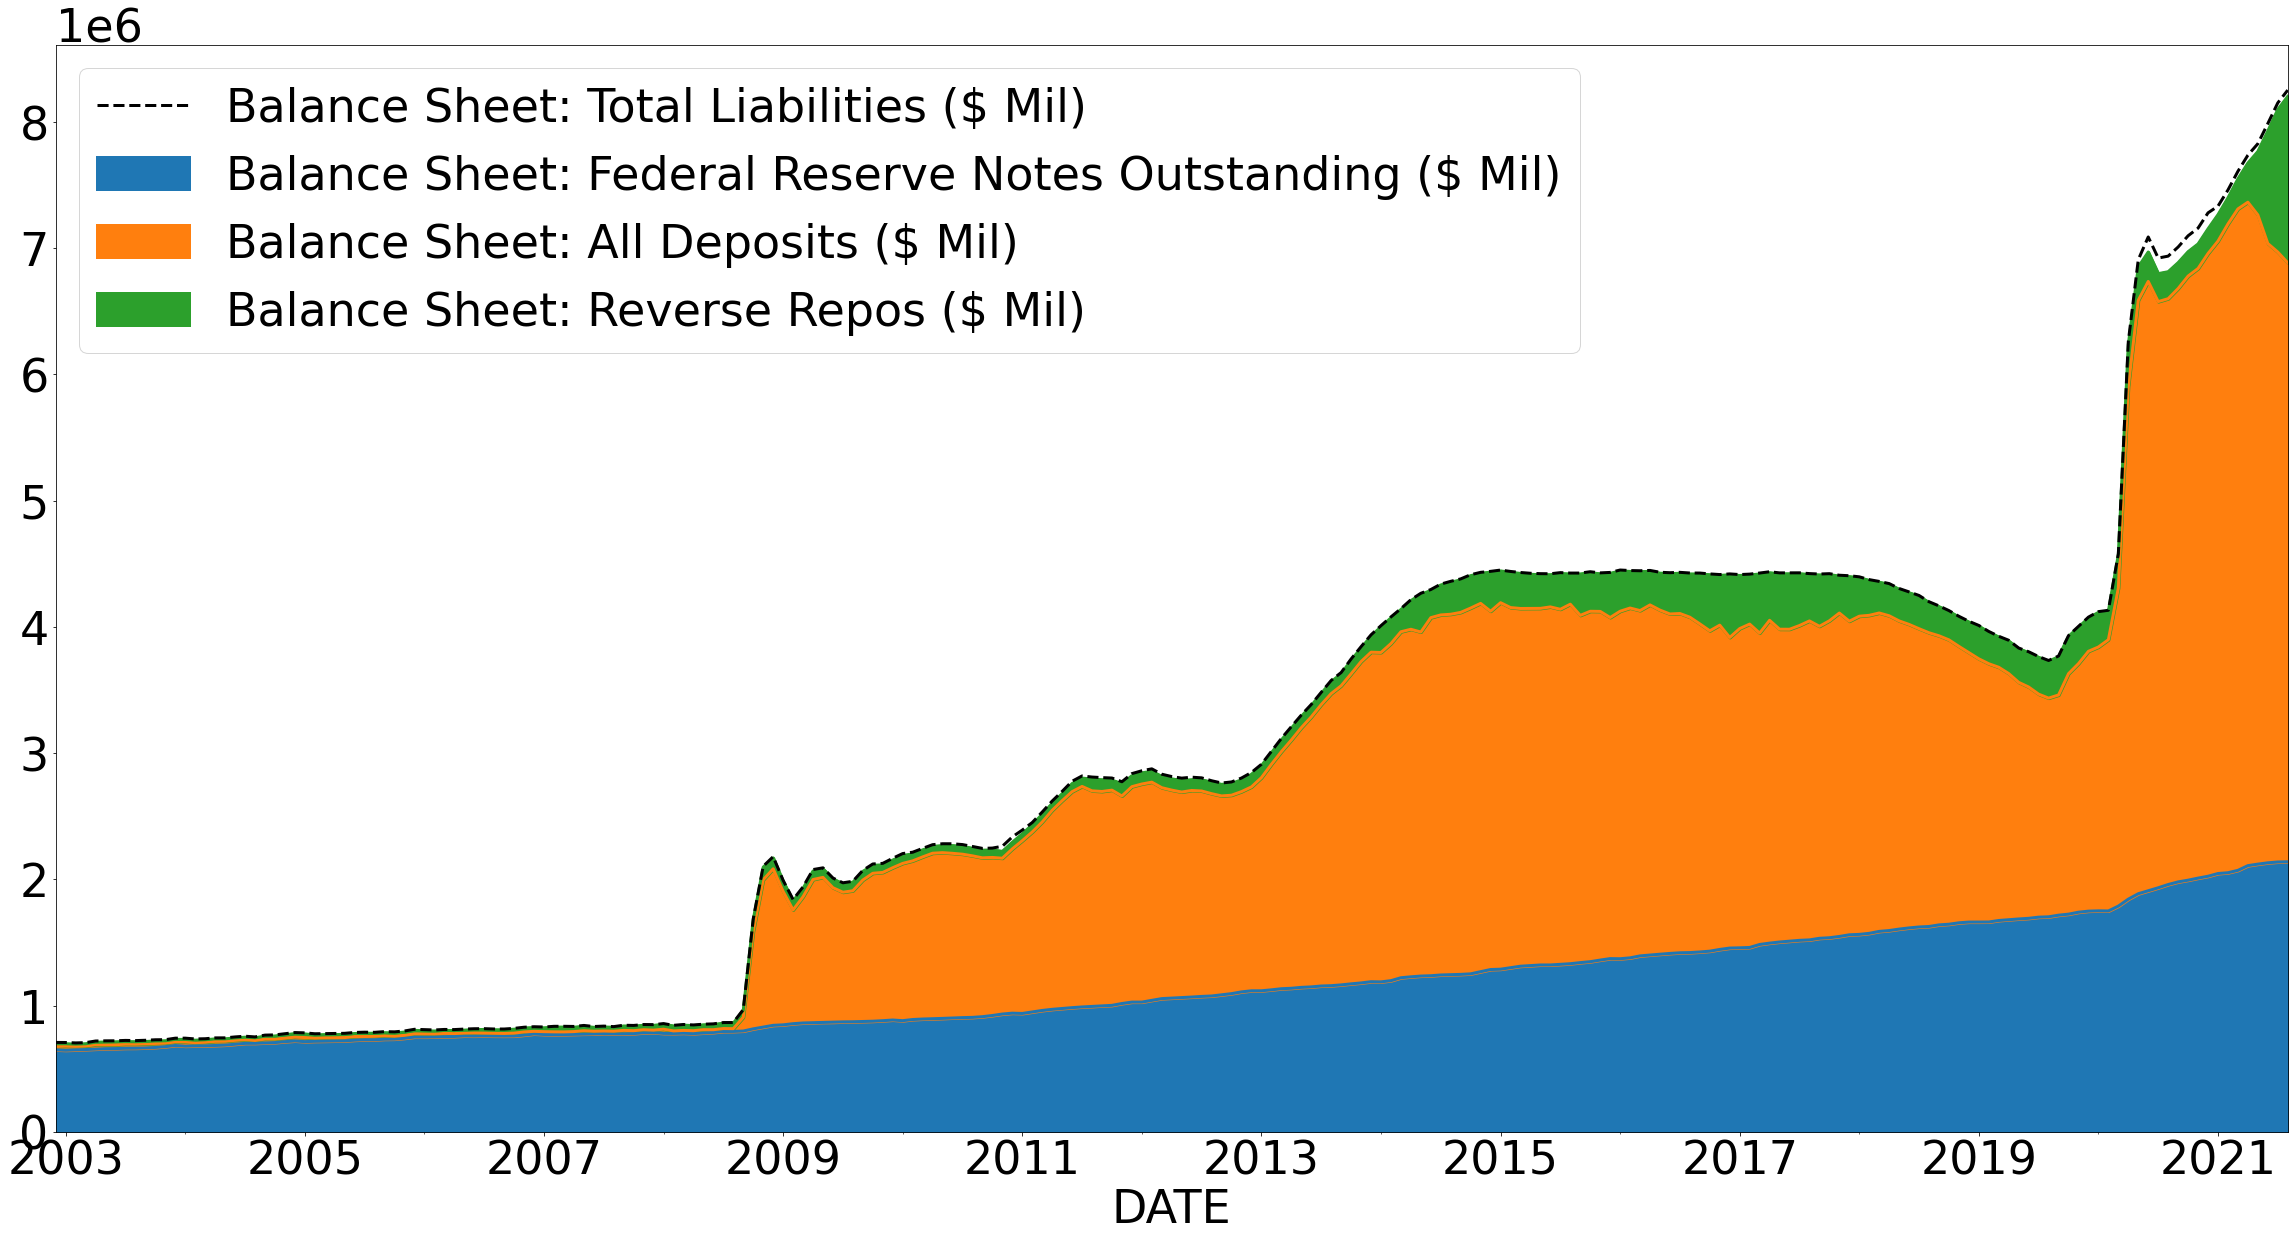

In [21]:
account_vars = ["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)",
                "Balance Sheet: All Deposits ($ Mil)",
                "Balance Sheet: Reverse Repos ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":], account_vars, linewidth = 3, total_var = "Balance Sheet: Total Liabilities ($ Mil)",
                  pp = pp)

In [22]:
data["Balance Sheet: Repos - Reverse Repos ($ Mil)"] =\
    data["Balance Sheet: Repos ($ Mil)"].sub(data["Balance Sheet: Reverse Repos ($ Mil)"])
data

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil),Vault Cash Used as Excess ($ Mil),Balance Sheet: Repos - Reverse Repos ($ Mil)
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-31,76400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.976774,NaN,NaN,5.277,NaN,NaN
1970-02-28,75200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.978214,NaN,NaN,4.863,NaN,NaN
1970-03-31,75300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.762258,NaN,NaN,4.732,NaN,NaN
1970-04-30,76300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.096333,NaN,NaN,4.772,NaN,NaN
1970-05-31,76600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.946452,NaN,NaN,4.805,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,6042100.0,2154819.25,7775974.00,7614925.00,7207246.25,4986900.00,2347.0,2217999.25,0.00,759.75,...,372836.75,5255878.75,NaN,0.25,0.069000,0.100000,NaN,NaN,NaN,-309901.75
2021-05-31,6041900.0,2167934.00,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.50,...,380029.00,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN,NaN,-502419.50
2021-06-30,6027100.0,2178871.20,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.00,...,332965.60,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN,NaN,-890891.60


<ipython-input-7-d2f49b60d242>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x, 2) for x in vals])


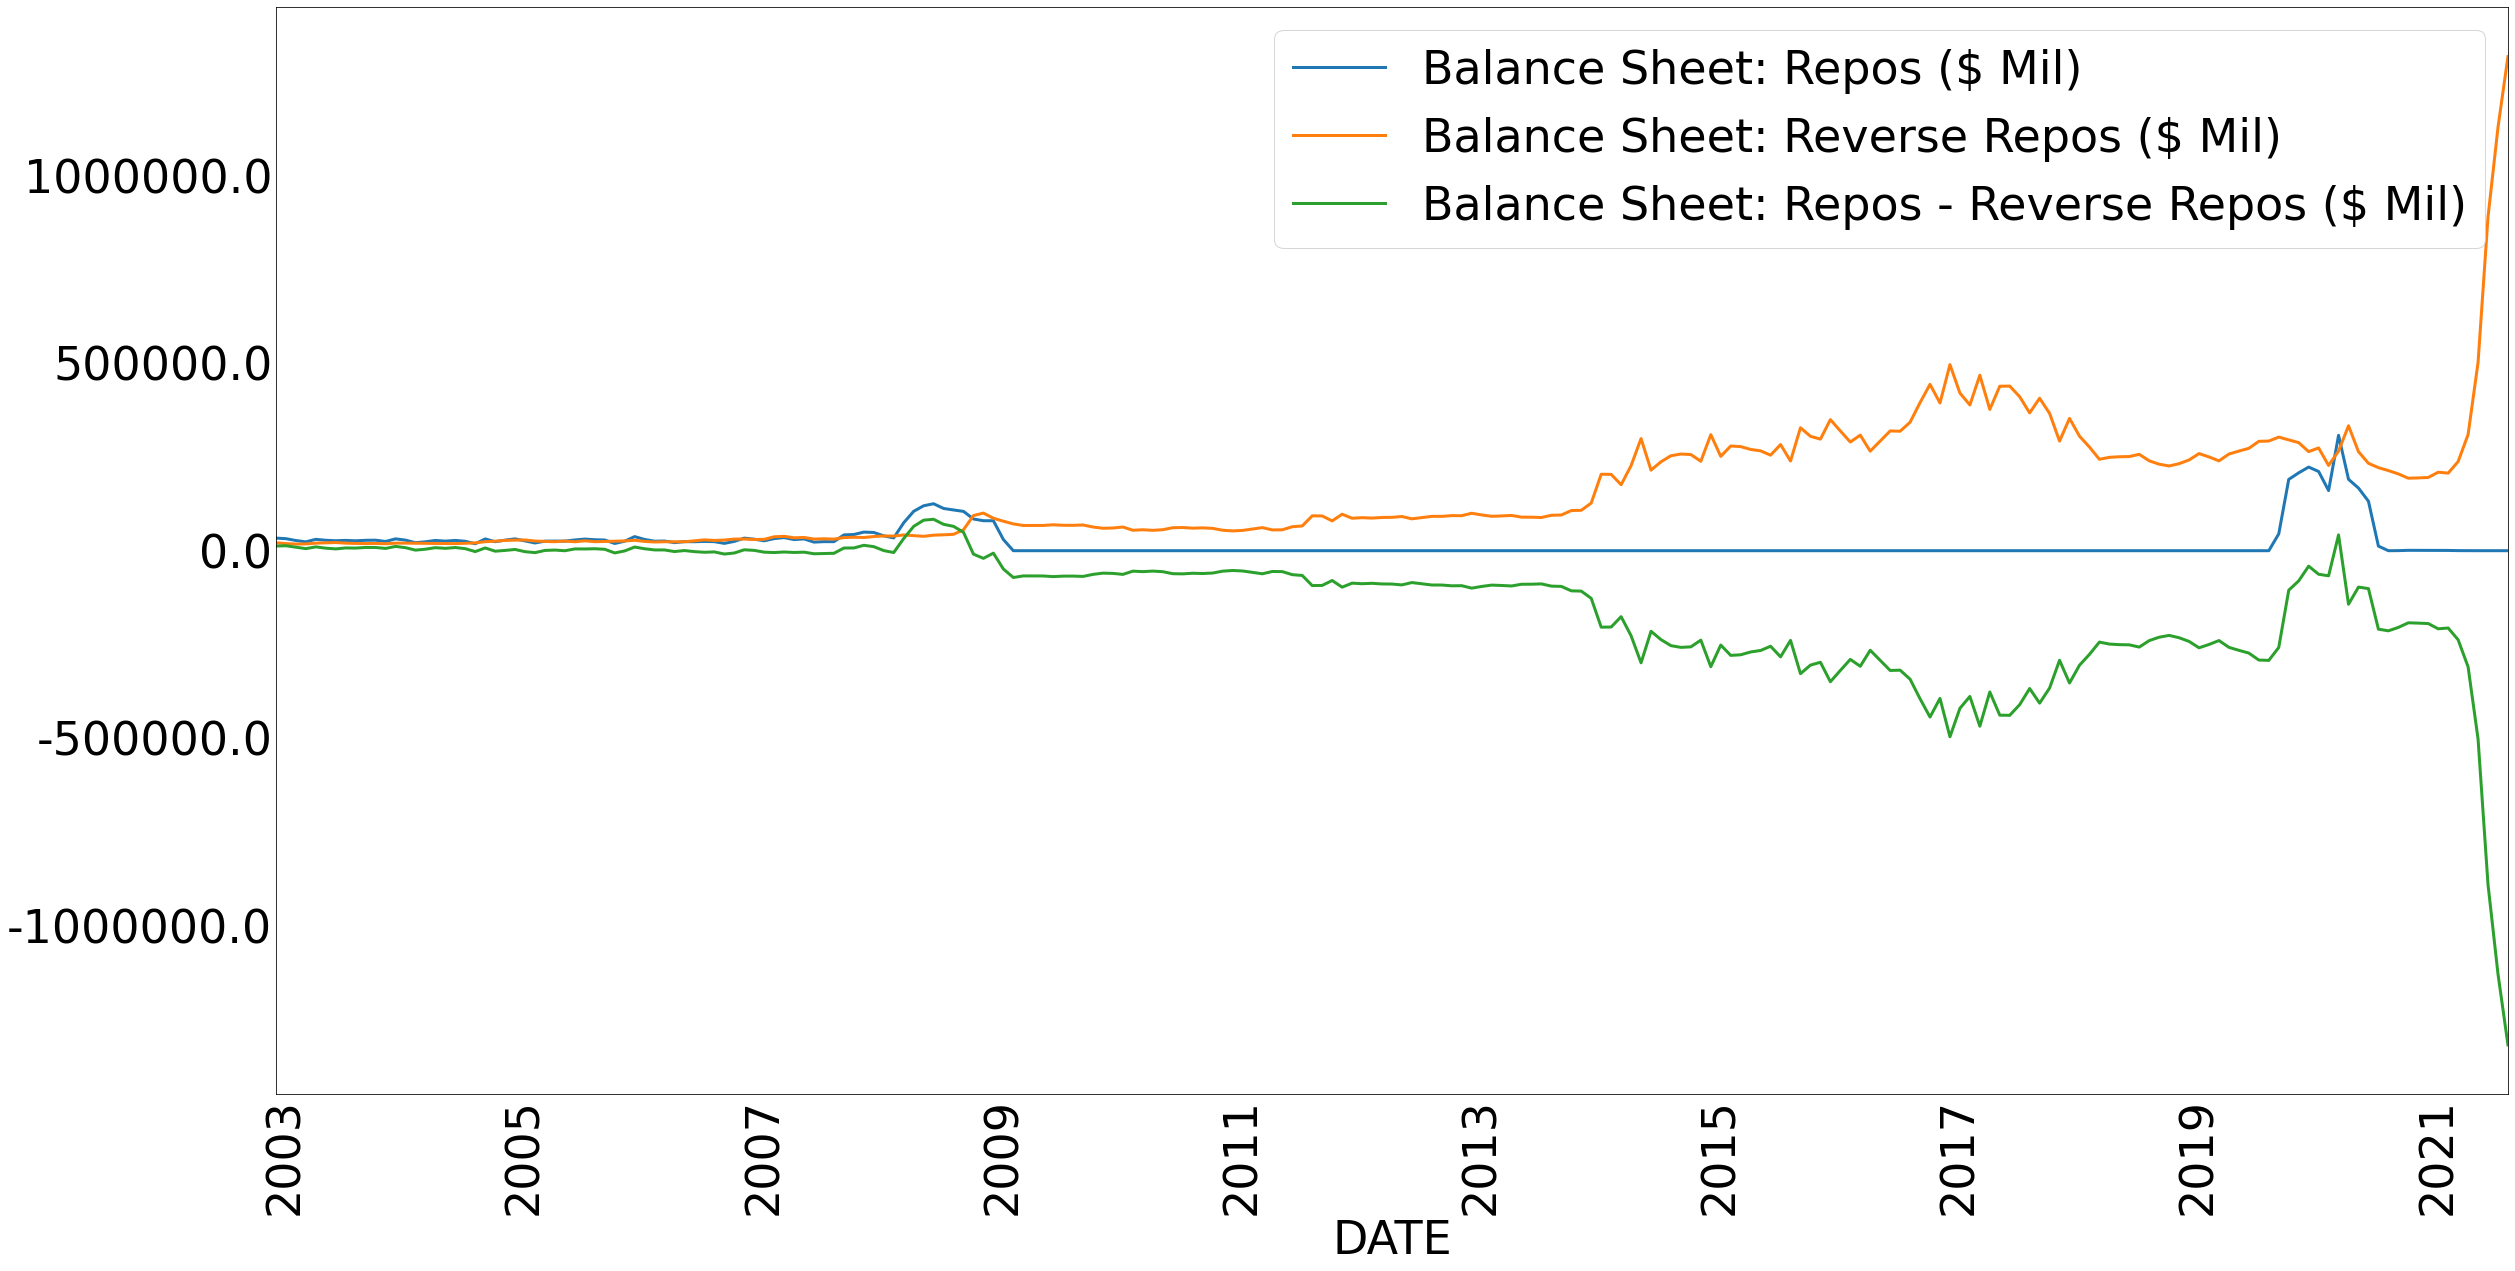

In [23]:
overnight_vars = ["Balance Sheet: Repos ($ Mil)",
                  "Balance Sheet: Reverse Repos ($ Mil)",
                  "Balance Sheet: Repos - Reverse Repos ($ Mil)"]

plot_lines(data[overnight_vars], linewidth = 3)


<ipython-input-7-d2f49b60d242>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x, 2) for x in vals])


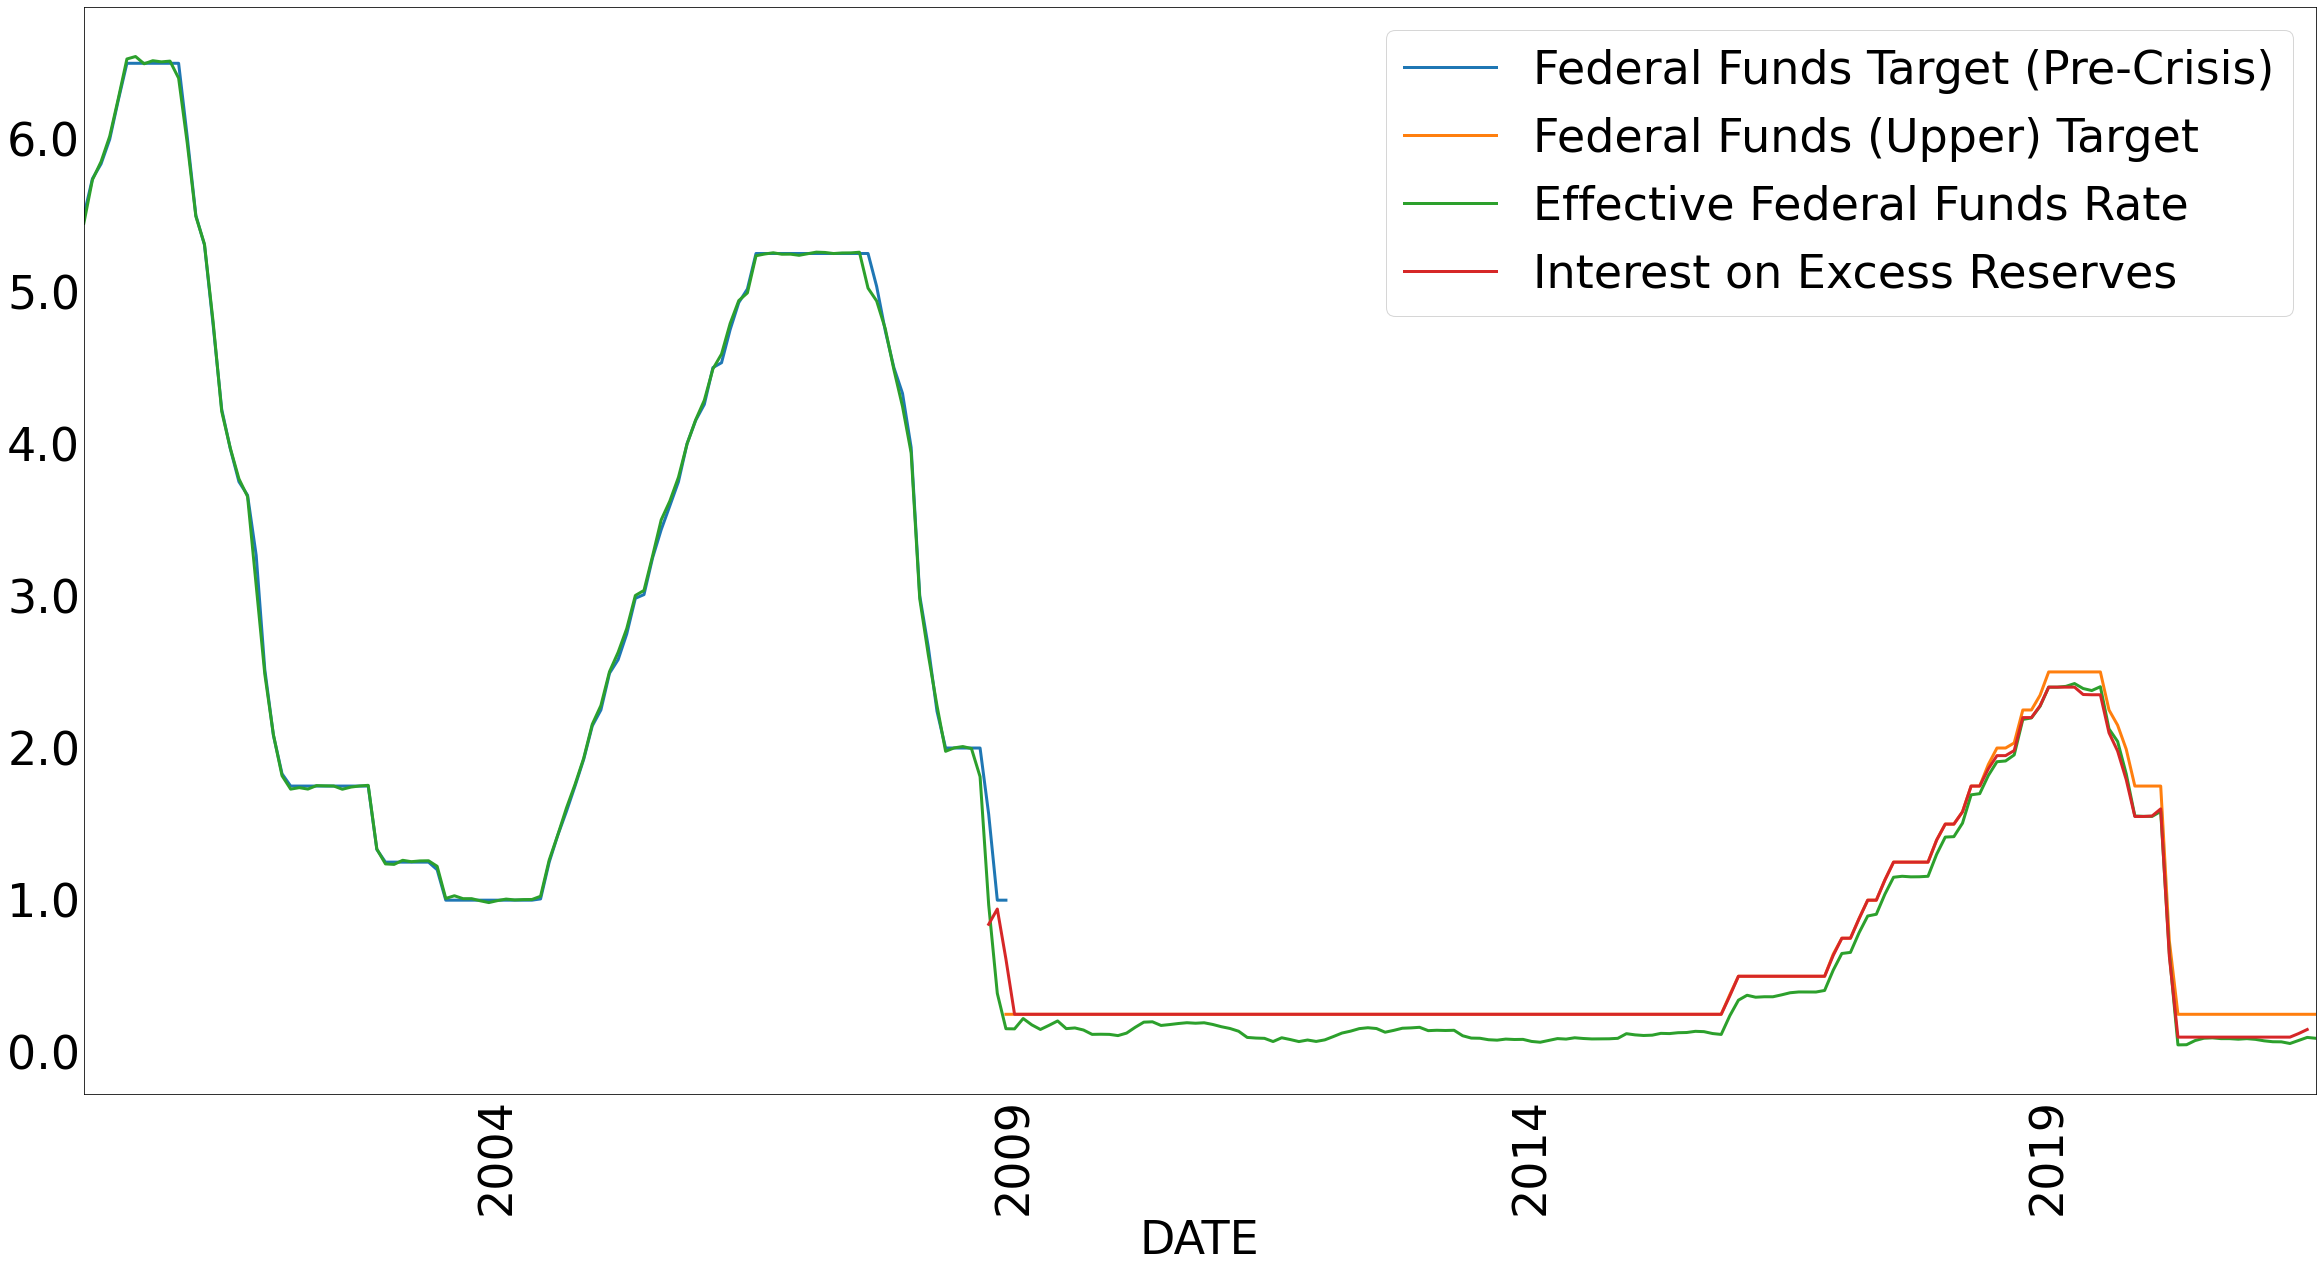

In [24]:
interest_vars = ["Federal Funds Target (Pre-Crisis)",
                  "Federal Funds (Upper) Target",
                  "Effective Federal Funds Rate",
                  "Interest on Excess Reserves"]
plot_lines(data.loc["2000":, interest_vars], linewidth = 3)